# 讀書會作業－1

我們將對近一年PTT股票版的資料進行分析，來看看甚麼股票討論度最高，及分析其情緒。

In [1]:
import pandas as pd
import jieba
import jieba.analyse
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import re
import time
import datetime
%matplotlib inline

In [2]:
# 設定圖的字體大小
plt.rcParams['font.size'] = 14

# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

# 設定文字雲中文字體路徑
FontPath = 'data/SourceHanSansTW-Regular.otf' # 設定字型

# plt.rcParams['font.sans-serif']=['SimHei'] #使 matplotilb 中文能正常顯示
fprop = fm.FontProperties(fname="./data/SourceHanSansTW-Regular.otf")


# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

In [3]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('./dict/dict.txt') 

# 載入自定義辭典：一個詞一行，每行分詞語、詞頻(可省)、詞性(可省)
# 加入一些網路術語，如：台GG、EPS......
# 參考連結：
# https://www.tdtn.tw/article/5#google_vignette
# https://www.ptt.cc/bbs/NSRS/M.1174374332.A.587.html
# https://www.bnext.com.tw/article/62714/stock-market-netizen-top-10
jieba.load_userdict('./dict/user_dict.txt')

Building prefix dict from c:\Users\james\OneDrive\桌面\研究所課程\社群媒體分析\HW\dict\dict.txt ...
Loading model from cache C:\Users\james\AppData\Local\Temp\jieba.u8e67916196e166e4dceb0ce577f48be7.cache
Loading model cost 0.392 seconds.
Prefix dict has been built successfully.


### 資料介紹
資料來源：
+ 工作流程平台蒐集PTT 股票版(Stock)文章
+ 關鍵字：選股、進場、新手、學生、菜鳥、小白、入場、建議、年輕、年青
+ 時間： 2023-03-21 ~ 2024-03-21
+ 資料筆數：共 2867 篇文章

In [5]:
# 由於工作流程平台資料筆數上限為10000，所以我們分三個檔案下載
df = pd.read_csv('data/Stock_data_fresh.csv')
df

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1             2  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   
2             3  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...   
3             4  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...   
4             5  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...   
...         ...                                                ...   
2862       2863  https://www.ptt.cc/bbs/Stock/M.1710996895.A.A7...   
2863       2864  https://www.ptt.cc/bbs/Stock/M.1710999313.A.A7...   
2864       2865  https://www.ptt.cc/bbs/Stock/M.1711014577.A.4E...   
2865       2866  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...   
2866       2867  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...   

                           artTitle              artDate     artPoster  \
0                   [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56     enouch777   
1     Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41        YU1225   
2         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 08:14:29       peter98   
3         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 09:32:58        YukiTW   
4         [新聞]外資大砍金融股！中信金遭賣15.73萬張最  2023-03-21 10:09:52       allfate   
...                             ...                  ...           ...   
2862                           [標的]  2024-03-21 12:54:53       CCF2016   
2863     [新聞]全住套房！00939破發觸及14.99元成交  2024-03-21 13:35:11  bmw606042001   
2864           Re:[請益]ETF跌破發行價，很正常？  2024-03-21 17:49:35          gcin   
2865                [心得]兩萬風口上，菜雞也能飛  2024-03-21 19:10:53        bm0406   
2866              [請益]為什麼不是選期貨是選正二？  2024-03-21 19:11:51      huabandd   

     artCatagory                                         artContent  \
0          Stock  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1          Stock  今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...   
2          Stock  技術分析的問題是  公說公有理  婆說婆有理\n\n你一旦說他沒道理  就有屁孩會來跟你說是...   
3          Stock  有一招技術分析，你可能聽過，\n就是創新高的股票，上無壓力，會繼續延伸氣勢，\n簡單來說，就...   
4          Stock  原文標題：\n\n外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍\n原...   
...          ...                                                ...   
2862       Stock  標的：2421.TW建準\n(例 2330.TW 台積電)\n分類：多\n\n分析/正文：散...   
2863       Stock  原文標題：\n\n\n全住套房！00939破發觸及14.99元 成交量逾28萬張\n\n原文...   
2864       Stock  股市小白\n\n這不就是一對套利想要收割上市行情\n\n結果看不到，只好賣一波\n\n大盤漲...   
2865       Stock  大家晚安，我是兩年前有發過文感嘆韭菜命格的奈米戶菜雞。\n\n當時發文後很多人建議心態調整，...   
2866       Stock  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   

                                             artComment             e_ip  \
0     [{"cmtStatus": "推", "cmtPoster": "devidevi", "...  111.184.170.175   
1     [{"cmtStatus": "推", "cmtPoster": "sdhpipt", "c...    106.1.120.140   
2     [{"cmtStatus": "推", "cmtPoster": "Altair", "cm...   73.195.162.171   
3     [{"cmtStatus": "推", "cmtPoster": "slayptter", ...   101.136.205.85   
4     [{"cmtStatus": "→", "cmtPoster": "sexybox", "c...    42.79.171.144   
...                                                 ...              ...   
2862  [{"cmtStatus": "推", "cmtPoster": "kutkin", "cm...     1.200.152.63   
2863  [{"cmtStatus": "→", "cmtPoster": "menti", "cmt...              NaN   
2864  [{"cmtStatus": "推", "cmtPoster": "strlen", "cm...   223.140.214.44   
2865  [{"cmtStatus": "→", "cmtPoster": "YesNoter", "...   49.158.195.139   
2866  [{"cmtStatus": "推", "cmtPoster": "panjanhon", ...   101.136.98.205   

             insertedDate dataSource  
0     2023-03-21 02:21:56        ptt  
1     2023-03-22 02:22:39        ptt  
2     2023-03-22 02:22:39        ptt  
3     2023-03-22 02:22:39        ptt  
4     2023-03-22 02:22:39        ptt  
...                   ...        ...  
2862  2024-03-22 02:04:53        ptt  
2863  2024-03-22 02:04:53        ptt  
2864  2024-03-22 02:05:00        ptt  
2865  2024-03-22 02:05:00        ptt  
2866  2024-03-22 02:05:00        ptt  

[2867 rows x 11 columns]

### 資料初步清理

In [6]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   
2  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...   
3  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...   
4  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...   
5  https://www.ptt.cc/bbs/Stock/M.1679364890.A.85...   
6  https://www.ptt.cc/bbs/Stock/M.1679368993.A.59...   
7  https://www.ptt.cc/bbs/Stock/M.1679370697.A.F1...   
8  https://www.ptt.cc/bbs/Stock/M.1679380739.A.E5...   
9  https://www.ptt.cc/bbs/Stock/M.1679383747.A.FD...   

                           artTitle              artDate  \
0                   [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
1     Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41   
2         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 08:14:29   
3         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 09:32:58   
4         [新聞]外資大砍金融股！中信金遭賣15.73萬張最  2023-03-21 10:09:52   
5  Re:[標的]00740B富邦投等債、00746B富邦A級債請益  2023-03-21 10:14:47   
6        [新聞]【Yahoo來選股】首季進入倒數！投信持股1  2023-03-21 11:23:09   
7            [新聞]南亞科估上半年跌價逐季縮小華邦電看營  2023-03-21 11:51:35   
8         [新聞]SVB和科技產業的緊密程度超乎想像，失去S  2023-03-21 14:38:57   
9          [新聞]兆豐金／【兆豐金法說】攸關50萬股東權益  2023-03-21 15:29:03   

                                          artContent  \
0  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...   
2  技術分析的問題是  公說公有理  婆說婆有理\n\n你一旦說他沒道理  就有屁孩會來跟你說是...   
3  有一招技術分析，你可能聽過，\n就是創新高的股票，上無壓力，會繼續延伸氣勢，\n簡單來說，就...   
4  原文標題：\n\n外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍\n原...   
5  投等跟非投等 對一般投資人 我個人建議不用想太多\n\n原因是債券除了評級外還有債券存續期間...   
6  原文標題：\n\n【Yahoo來選股】首季進入倒數！投信持股逾10%標的 季底作帳加溫\n原...   
7  原文標題：\n\n南亞科估上半年跌價逐季縮小 華邦電看營運首季落底\n\n原文連結：\nht...   
8  原文標題：\n\nSVB和科技產業的緊密程度超乎想像，失去SVB，矽谷和科技產業將走向何方\...   
9  原文標題：\n\n兆豐金／【兆豐金法說】攸關50萬股東權益！兆豐金總經理：將動用保留盈餘 維...   

                                            sentence  
0  1. 標的：      2646.TW星宇航空。2. 分類：討論。3. 分析/正文：，剛剛看...  
1  今天沒意外準備反彈 、，南山人壽已經澄清部位非常少，股價根本過度反應 反彈最少10%，至於潤...  
2  技術分析的問題是  公說公有理  婆說婆有理。你一旦說他沒道理  就有屁孩會來跟你說是學藝不...  
3  有一招技術分析，你可能聽過，，就是創新高的股票，上無壓力，會繼續延伸氣勢，，簡單來說，就是去...  
4  原文標題：。外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍，原文連結：...  
5  投等跟非投等 對一般投資人 我個人建議不用想太多。原因是債券除了評級外還有債券存續期間的變數...  
6  原文標題：。【Yahoo來選股】首季進入倒數！投信持股逾10%標的 季底作帳加溫，原文連結：...  
7  原文標題：。南亞科估上半年跌價逐季縮小 華邦電看營運首季落底。原文連結：， 18:37:33...  
8  原文標題：。SVB和科技產業的緊密程度超乎想像，失去SVB，矽谷和科技產業將走向何方。原文連...  
9  原文標題：。兆豐金／【兆豐金法說】攸關50萬股東權益！兆豐金總經理：將動用保留盈餘 維持股利...

### 斷句

In [7]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
2  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
5  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
6  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
7  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
8  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
9  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   

                        artTitle              artDate  \
0                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
1                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
2                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
3                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
4                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
5                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
6                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
7                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
8                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
9  Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41   

                                          artContent                 sentence  
0  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...  1. 標的：      2646.TW星宇航空  
1  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                 2. 分類：討論  
2  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                3. 分析/正文：  
3  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...             剛剛看到3C頻道邦尼幫你  
4  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...            測試星宇的經濟艙有什麼東西  
5  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                    60w快充  
6  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                  雖然實測都不到  
7  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...              就知道至少有一定流暢度  
8  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                           
9  今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...              今天沒意外準備反彈 、

### 斷詞

In [8]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

artUrl  \
0   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
2   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
3   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
4   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
5   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
6   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
7   https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
9   https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   
10  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   

                         artTitle              artDate  \
0                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
1                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
2                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
3                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
4                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
5                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
6                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
7                 [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56   
9   Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41   
10  Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41   

                                           artContent              sentence  
0   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...  1 標的      2646TW星宇航空  
1   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                2 分類討論  
2   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                3 分析正文  
3   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...          剛剛看到3C頻道邦尼幫你  
4   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...         測試星宇的經濟艙有什麼東西  
5   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...                 60w快充  
6   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...               雖然實測都不到  
7   1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...           就知道至少有一定流暢度  
9   今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...            今天沒意外準備反彈   
10  今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...         南山人壽已經澄清部位非常少

使用jieba進行斷詞

In [9]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

artUrl         artTitle  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
2  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
2  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   

               artDate                                         artContent  \
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
2  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
2  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   

     word  
0      標的  
0  2646TW  
0      星宇  
0      航空  
1      分類  
1      討論  
2      分析  
2      正文  
3      剛剛  
3      看到

### 停用字

In [10]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('dict/stopwords.txt', 'r', encoding='utf-8').readlines()] 

In [11]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]
noStop_df.head(10)

artUrl         artTitle  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   

               artDate                                         artContent  \
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
4  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   

     word  
0      標的  
0  2646TW  
0      星宇  
0      航空  
1      討論  
3      剛剛  
3      3C  
3      頻道  
3      邦尼  
4      測試

### 視覺化結果

#### 繪製詞頻為前10高的長條圖

In [12]:
freq_df = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df

C:\Users\james\AppData\Local\Temp\ipykernel_21004\4007478613.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0         投資   2800
1        ETF   2453
2         市場   2359
3         台灣   1812
4         台股   1771
...      ...    ...
52089     這包      1
52090     據陸      1
52091  33637      1
52092   3374      1
52093  25043      1

[52094 rows x 2 columns]

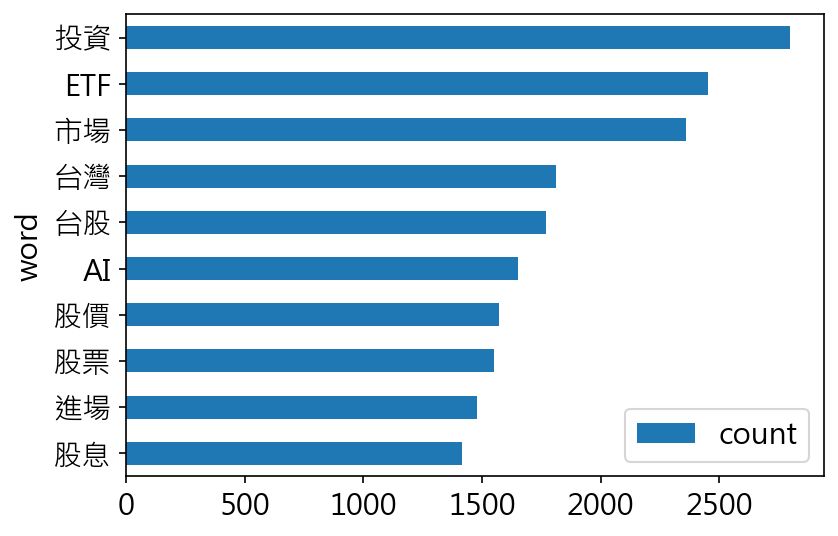

In [13]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

#### 繪製文字雲

In [14]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

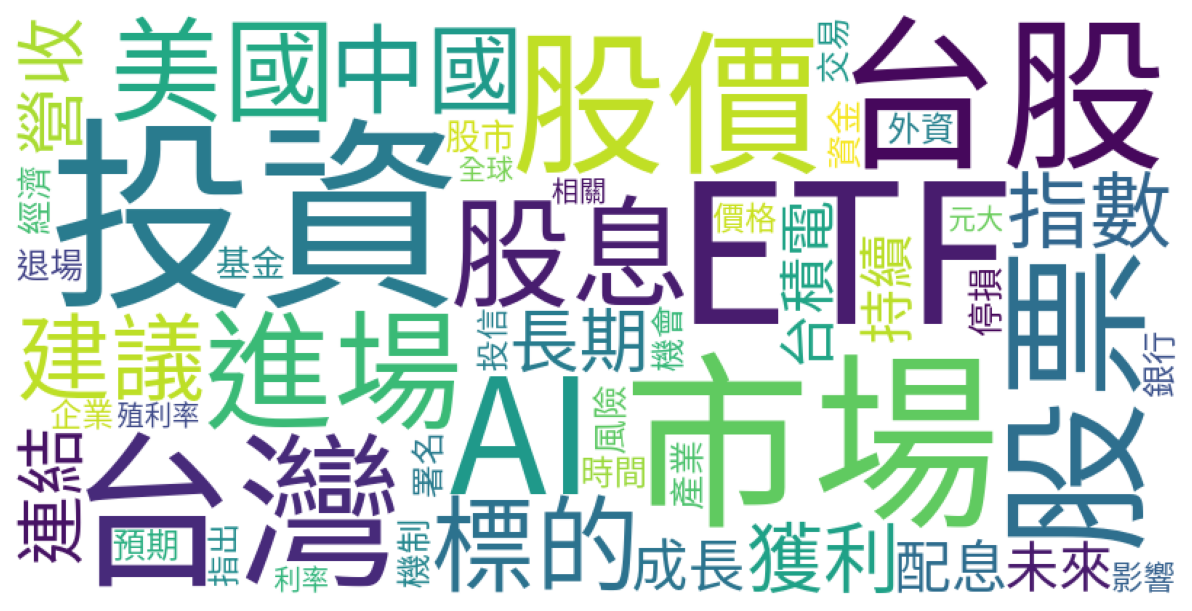

In [15]:
# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400, font_path = FontPath, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 更新停用字字典

In [16]:
# 參數形式手動加入停用字
stopwords_manual = ["原文", "來源", "標題", "今年", "目前", "JPTT", "評論", "現在", "連結", "去年", "內容", "表示"]
stopwords.extend(stopwords_manual)

In [17]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

artUrl         artTitle  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   

               artDate                                         artContent  \
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
4  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   

     word  
0      標的  
0  2646TW  
0      星宇  
0      航空  
1      討論  
3      剛剛  
3      3C  
3      頻道  
3      邦尼  
4      測試

重新清除停用字

In [18]:
#去除停用字
nostop_df_updated = word_df[~word_df['word'].isin(stopwords)]

nostop_df_updated.head(10)

artUrl         artTitle  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  [標的]星宇航空座艙科技點滿多   

               artDate                                         artContent  \
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
0  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
4  2023-03-21 00:30:56  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   

     word  
0      標的  
0  2646TW  
0      星宇  
0      航空  
1      討論  
3      剛剛  
3      3C  
3      頻道  
3      邦尼  
4      測試

#### 重新計算詞頻

#### 重新繪製詞頻長條圖

In [19]:
freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df

C:\Users\james\AppData\Local\Temp\ipykernel_21004\36813476.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_updated = pd.DataFrame(pd.value_counts(nostop_df_updated['word'])).sort_values(by = ['count'], ascending = False).reset_index()


word  count
0         投資   2800
1        ETF   2453
2         市場   2359
3         台灣   1812
4         台股   1771
...      ...    ...
52089     這包      1
52090     據陸      1
52091  33637      1
52092   3374      1
52093  25043      1

[52094 rows x 2 columns]

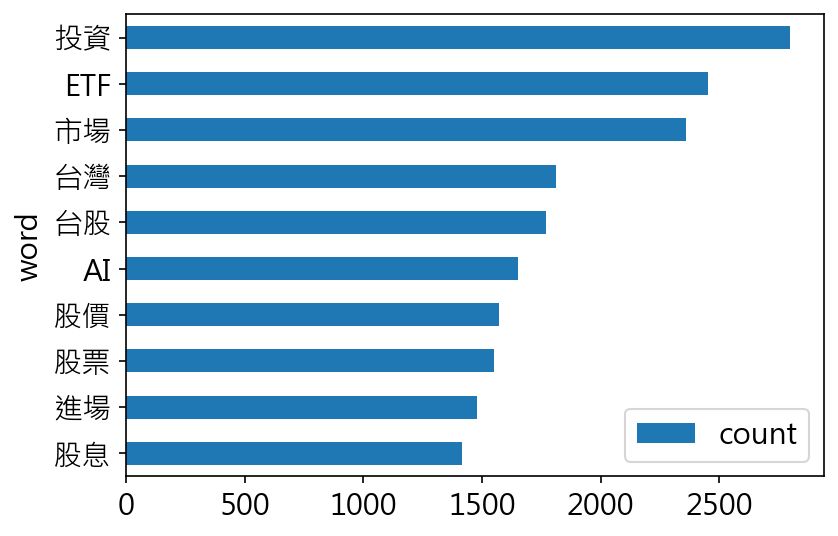

In [20]:
freq_df_updated.head(10).plot.barh(x='word', y='count').invert_yaxis()
plt.show()

#### 繪製文字雲

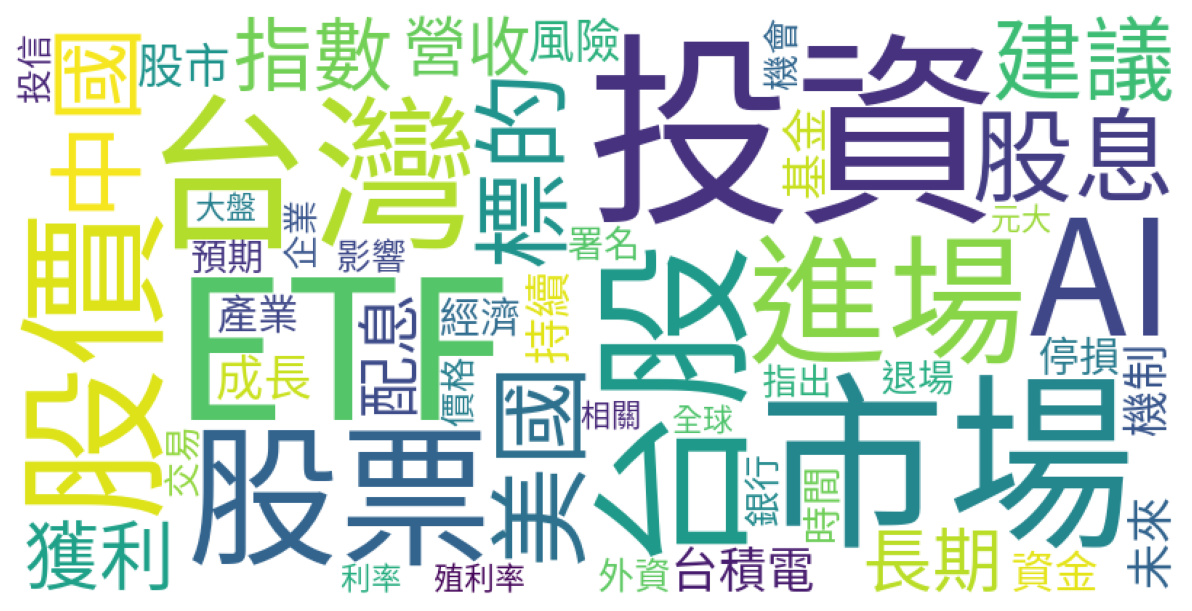

In [21]:
freq_dict_updated = freq_df_updated.set_index('word').to_dict()
freq_dict_updated = freq_dict_updated['count']

# 繪製文字雲
wordcloud_after = WordCloud(background_color='white', width=800, height = 400, font_path = FontPath, max_words = 50)
wordcloud_after.generate_from_frequencies(freq_dict_updated)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_after)
plt.axis('off')
plt.show()

### 比較清理前後的文字雲

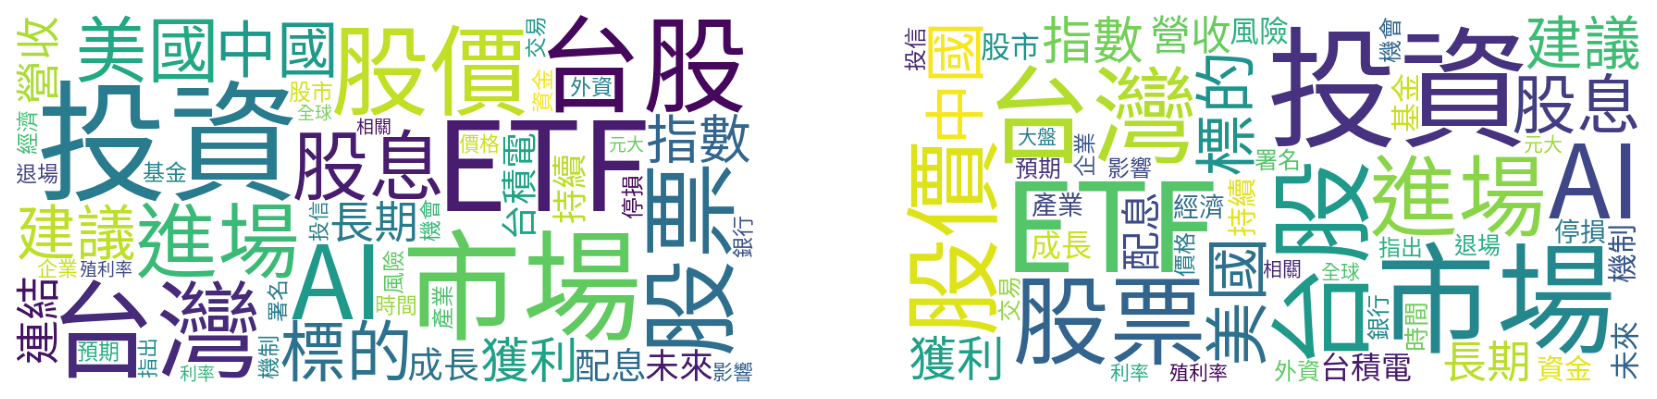

In [22]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud)
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wordcloud_after)
plt.axis('off')

plt.show()

儲存clean data，以便後續其他使用

In [23]:
nostop_df_updated.to_csv("data/clean_zh_data.csv", encoding = 'utf-8',index = False)
#nostop_df_updated = pd.read_csv('data/clean_zh_data_week.csv')

In [24]:
nostop_df_updated["artDate"] = pd.to_datetime(nostop_df_updated["artDate"])
nostop_df_updated['artDate'] = nostop_df_updated['artDate'].dt.date 

C:\Users\james\AppData\Local\Temp\ipykernel_21004\3233721504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nostop_df_updated["artDate"] = pd.to_datetime(nostop_df_updated["artDate"])
C:\Users\james\AppData\Local\Temp\ipykernel_21004\3233721504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nostop_df_updated['artDate'] = nostop_df_updated['artDate'].dt.date


### Lexicon-based 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

In [25]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})

### 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [26]:
ptt_liwc_df = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df

artUrl     artDate  \
0       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
1       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
2       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
3       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
4       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
...                                                   ...         ...   
467166  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  2024-03-21   
467167  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  2024-03-21   
467168  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  2024-03-21   
467169  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  2024-03-21   
467170  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  2024-03-21   

                 artTitle                                         artContent  \
0         [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1         [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
2         [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3         [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
4         [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
...                   ...                                                ...   
467166  [請益]為什麼不是選期貨是選正二？  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
467167  [請益]為什麼不是選期貨是選正二？  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
467168  [請益]為什麼不是選期貨是選正二？  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
467169  [請益]為什麼不是選期貨是選正二？  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
467170  [請益]為什麼不是選期貨是選正二？  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   

          word sentiments  
0           標的        NaN  
1       2646TW        NaN  
2           星宇        NaN  
3           航空        NaN  
4           討論        NaN  
...        ...        ...  
467166   41796        NaN  
467167     最高點        NaN  
467168      位是        NaN  
467169    1943        NaN  
467170   25043        NaN  

[467171 rows x 6 columns]

### 正負向情緒詞彙頻率折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [27]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative") 
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

artDate sentiments  size
3     2023-03-21   negative    36
4     2023-03-21   positive    38
9     2023-03-22   negative    19
10    2023-03-22   positive    50
15    2023-03-23   negative    17
...          ...        ...   ...
1895  2024-03-19   positive    56
1899  2024-03-20   negative    34
1900  2024-03-20   positive    89
1905  2024-03-21   negative     9
1906  2024-03-21   positive    32

[673 rows x 3 columns]

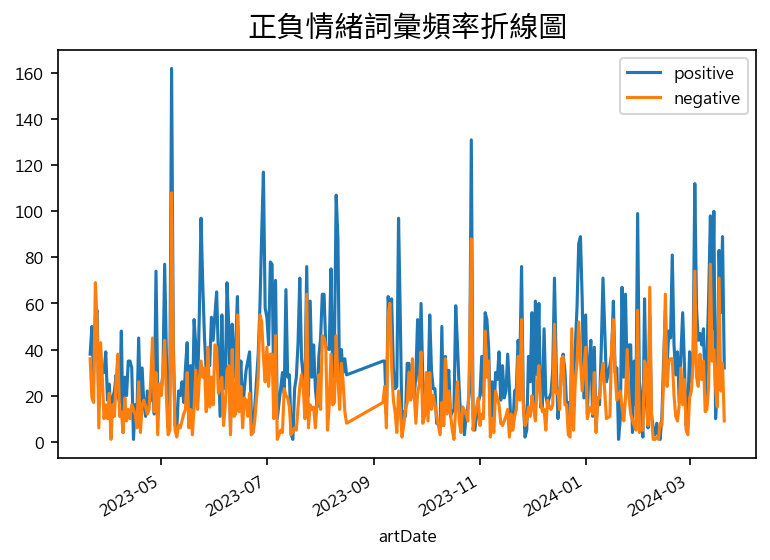

In [28]:
plt.rcParams['font.size'] = 8

colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

```Moving average```

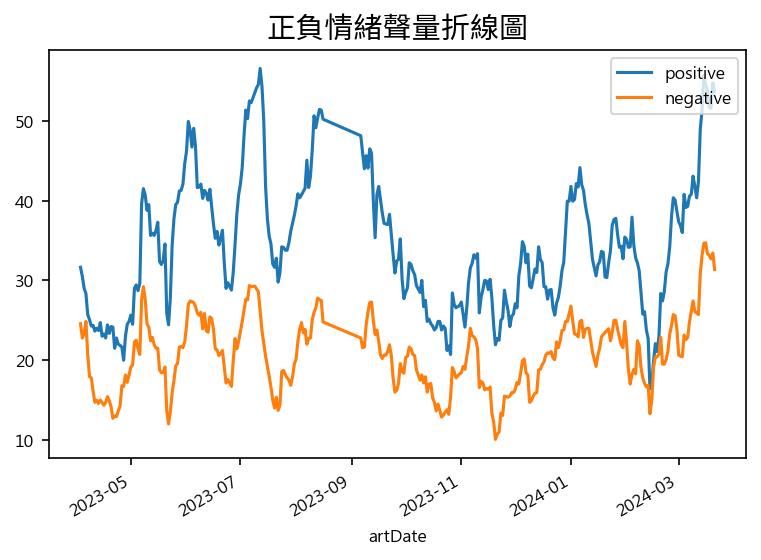

In [30]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 2 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒聲量折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

### 正負向情緒詞彙比例折線圖圖

In [31]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

artDate sentiments  size     ratio
3     2023-03-21   negative    36  0.486486
4     2023-03-21   positive    38  0.513514
9     2023-03-22   negative    19  0.275362
10    2023-03-22   positive    50  0.724638
15    2023-03-23   negative    17  0.369565
...          ...        ...   ...       ...
1895  2024-03-19   positive    56  0.717949
1899  2024-03-20   negative    34  0.276423
1900  2024-03-20   positive    89  0.723577
1905  2024-03-21   negative     9  0.219512
1906  2024-03-21   positive    32  0.780488

[673 rows x 4 columns]

Text(0.5, 1.0, '正負情緒比例折線圖')

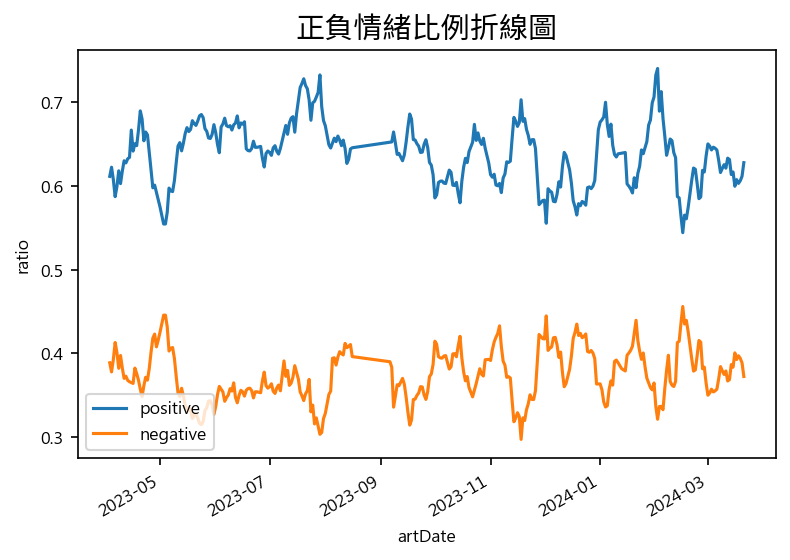

In [32]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 正負向情緒分數折線圖

In [33]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

artDate  negative  positive
0  2023-03-21      36.0      38.0
1  2023-03-22      19.0      50.0
2  2023-03-23      17.0      29.0
3  2023-03-24      69.0      54.0
4  2023-03-25      52.0      57.0

In [34]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["negative"]
)
ptt_sentiment_value.head()

artDate  negative  positive  sentiment_value
0  2023-03-21      36.0      38.0              2.0
1  2023-03-22      19.0      50.0             31.0
2  2023-03-23      17.0      29.0             12.0
3  2023-03-24      69.0      54.0            -15.0
4  2023-03-25      52.0      57.0              5.0

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

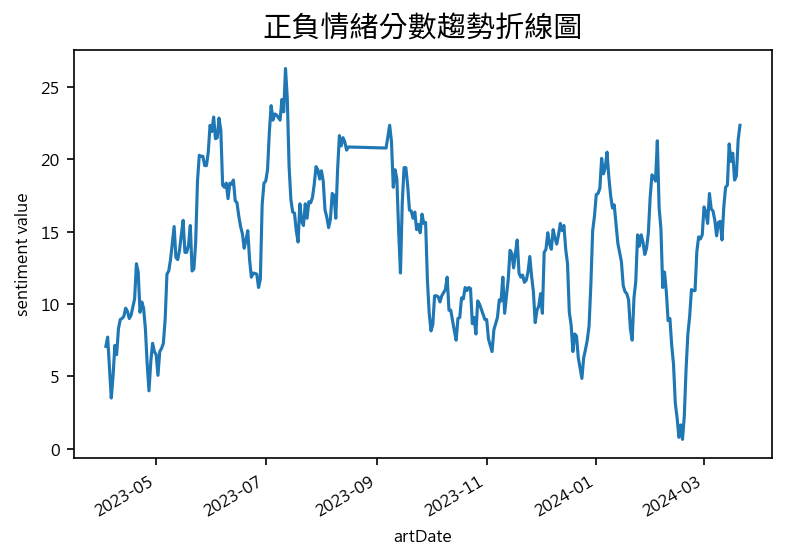

In [36]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 文章為單位的情緒分析

In [37]:
sentiment_count_by_article = pd.DataFrame(
    ptt_liwc_df.groupby(["artUrl", "sentiments"]).size()
).reset_index()
sentiment_count_by_article = sentiment_count_by_article.rename(columns={0: "size"})
sentiment_count_by_article

artUrl sentiments  size
0     https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...     affect     7
1     https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   negative     1
2     https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   positive     4
3     https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...     affect     2
4     https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...        anx     1
...                                                 ...        ...   ...
8852  https://www.ptt.cc/bbs/Stock/M.1710999313.A.A7...   positive     1
8853  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...     affect     7
8854  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...   negative     1
8855  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...   positive     4
8856  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...        sad     1

[8857 rows x 3 columns]

In [38]:
ptt_sentiment_value_by_article = (
    sentiment_count_by_article.pivot_table(
        index="artUrl", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...     7.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...     2.0    0.0  1.0   
2  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...     6.0    0.0  3.0   
3  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...     9.0    1.0  2.0   
4  https://www.ptt.cc/bbs/Stock/M.1679364890.A.85...    12.0    0.0  8.0   

   negative  positive  sad  
0       1.0       4.0  0.0  
1       2.0       0.0  0.0  
2       3.0       2.0  0.0  
3       4.0       3.0  0.0  
4       8.0       1.0  0.0

In [39]:
# sentiment 計算方式: positive - negative
ptt_sentiment_value_by_article["sentiment_value"] = (
    ptt_sentiment_value_by_article["positive"]
    - ptt_sentiment_value_by_article["negative"]
)
ptt_sentiment_value_by_article.head()

artUrl  affect  anger  anx  \
0  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...     7.0    0.0  0.0   
1  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...     2.0    0.0  1.0   
2  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...     6.0    0.0  3.0   
3  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...     9.0    1.0  2.0   
4  https://www.ptt.cc/bbs/Stock/M.1679364890.A.85...    12.0    0.0  8.0   

   negative  positive  sad  sentiment_value  
0       1.0       4.0  0.0              3.0  
1       2.0       0.0  0.0             -2.0  
2       3.0       2.0  0.0             -1.0  
3       4.0       3.0  0.0             -1.0  
4       8.0       1.0  0.0             -7.0

In [40]:
ptt_sentiment_value_by_article['sentiment_class'] = ptt_sentiment_value_by_article['sentiment_value'].apply(lambda x: "正向" if x > 0 else "負向" )
ptt_sentiment_value_by_article

artUrl  affect  anger  anx  \
0     https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...     7.0    0.0  0.0   
1     https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...     2.0    0.0  1.0   
2     https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...     6.0    0.0  3.0   
3     https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...     9.0    1.0  2.0   
4     https://www.ptt.cc/bbs/Stock/M.1679364890.A.85...    12.0    0.0  8.0   
...                                                 ...     ...    ...  ...   
2453  https://www.ptt.cc/bbs/Stock/M.1710991451.A.28...     3.0    0.0  0.0   
2454  https://www.ptt.cc/bbs/Stock/M.1710994274.A.71...    14.0    0.0  0.0   
2455  https://www.ptt.cc/bbs/Stock/M.1710996895.A.A7...     1.0    0.0  0.0   
2456  https://www.ptt.cc/bbs/Stock/M.1710999313.A.A7...     1.0    0.0  0.0   
2457  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...     7.0    0.0  0.0   

      negative  positive  sad  sentiment_value sentiment_class  
0          1.0       4.0  0.0              3.0              正向  
1          2.0       0.0  0.0             -2.0              負向  
2          3.0       2.0  0.0             -1.0              負向  
3          4.0       3.0  0.0             -1.0              負向  
4          8.0       1.0  0.0             -7.0              負向  
...        ...       ...  ...              ...             ...  
2453       1.0       0.0  1.0             -1.0              負向  
2454       0.0      14.0  0.0             14.0              正向  
2455       1.0       0.0  0.0             -1.0              負向  
2456       0.0       1.0  0.0              1.0              正向  
2457       1.0       4.0  1.0              3.0              正向  

[2458 rows x 9 columns]

In [41]:
clear_df_sentiment = pd.merge(df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
clear_df_sentiment["artDate"] = pd.to_datetime(clear_df_sentiment["artDate"])
clear_df_sentiment['artDate'] = clear_df_sentiment['artDate'].dt.date
clear_df_sentiment

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1             2  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   
2             3  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...   
3             4  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...   
4             5  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...   
...         ...                                                ...   
2862       2863  https://www.ptt.cc/bbs/Stock/M.1710996895.A.A7...   
2863       2864  https://www.ptt.cc/bbs/Stock/M.1710999313.A.A7...   
2864       2865  https://www.ptt.cc/bbs/Stock/M.1711014577.A.4E...   
2865       2866  https://www.ptt.cc/bbs/Stock/M.1711019455.A.AA...   
2866       2867  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...   

                           artTitle     artDate     artPoster artCatagory  \
0                   [標的]星宇航空座艙科技點滿多  2023-03-21     enouch777       Stock   
1     Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21        YU1225       Stock   
2         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21       peter98       Stock   
3         Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21        YukiTW       Stock   
4         [新聞]外資大砍金融股！中信金遭賣15.73萬張最  2023-03-21       allfate       Stock   
...                             ...         ...           ...         ...   
2862                           [標的]  2024-03-21       CCF2016       Stock   
2863     [新聞]全住套房！00939破發觸及14.99元成交  2024-03-21  bmw606042001       Stock   
2864           Re:[請益]ETF跌破發行價，很正常？  2024-03-21          gcin       Stock   
2865                [心得]兩萬風口上，菜雞也能飛  2024-03-21        bm0406       Stock   
2866              [請益]為什麼不是選期貨是選正二？  2024-03-21      huabandd       Stock   

                                             artContent  \
0     1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1     今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...   
2     技術分析的問題是  公說公有理  婆說婆有理\n\n你一旦說他沒道理  就有屁孩會來跟你說是...   
3     有一招技術分析，你可能聽過，\n就是創新高的股票，上無壓力，會繼續延伸氣勢，\n簡單來說，就...   
4     原文標題：\n\n外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍\n原...   
...                                                 ...   
2862  標的：2421.TW建準\n(例 2330.TW 台積電)\n分類：多\n\n分析/正文：散...   
2863  原文標題：\n\n\n全住套房！00939破發觸及14.99元 成交量逾28萬張\n\n原文...   
2864  股市小白\n\n這不就是一對套利想要收割上市行情\n\n結果看不到，只好賣一波\n\n大盤漲...   
2865  大家晚安，我是兩年前有發過文感嘆韭菜命格的奈米戶菜雞。\n\n當時發文後很多人建議心態調整，...   
2866  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   

                                             artComment             e_ip  \
0     [{"cmtStatus": "推", "cmtPoster": "devidevi", "...  111.184.170.175   
1     [{"cmtStatus": "推", "cmtPoster": "sdhpipt", "c...    106.1.120.140   
2     [{"cmtStatus": "推", "cmtPoster": "Altair", "cm...   73.195.162.171   
3     [{"cmtStatus": "推", "cmtPoster": "slayptter", ...   101.136.205.85   
4     [{"cmtStatus": "→", "cmtPoster": "sexybox", "c...    42.79.171.144   
...                                                 ...              ...   
2862  [{"cmtStatus": "推", "cmtPoster": "kutkin", "cm...     1.200.152.63   
2863  [{"cmtStatus": "→", "cmtPoster": "menti", "cmt...              NaN   
2864  [{"cmtStatus": "推", "cmtPoster": "strlen", "cm...   223.140.214.44   
2865  [{"cmtStatus": "→", "cmtPoster": "YesNoter", "...   49.158.195.139   
2866  [{"cmtStatus": "推", "cmtPoster": "panjanhon", ...   101.136.98.205   

             insertedDate dataSource sentiment_class  
0     2023-03-21 02:21:56        ptt             NaN  
1     2023-03-22 02:22:39        ptt              正向  
2     2023-03-22 02:22:39        ptt              負向  
3     2023-03-22 02:22:39        ptt              負向  
4     2023-03-22 02:22:39        ptt              負向  
...                   ...        ...             ...  
2862  2024-03-22 02:04:53        ptt              負向  
2863  2024-03-22 02:04:53        ptt              正向  
2864  2024-03-22 02:05:00        ptt             NaN  
2865  2024-03-22 02:05:00        ptt              正向  
2866  2024-03

In [42]:
sentiment_art_count = pd.DataFrame(
    clear_df_sentiment.groupby(["artDate", "sentiment_class"]).size()
).reset_index()
sentiment_art_count = sentiment_art_count.rename(columns={0: "size"})
sentiment_art_count = sentiment_art_count.sort_values(["artDate"])
sentiment_art_count

artDate sentiment_class  size
0    2023-03-21              正向     5
1    2023-03-21              負向     6
2    2023-03-22              正向     7
3    2023-03-22              負向     3
4    2023-03-23              正向     5
..          ...             ...   ...
629  2024-03-19              負向     2
630  2024-03-20              正向    17
631  2024-03-20              負向     4
632  2024-03-21              正向     6
633  2024-03-21              負向     4

[634 rows x 3 columns]

Text(0.5, 1.0, '正負文章數趨勢折線圖')

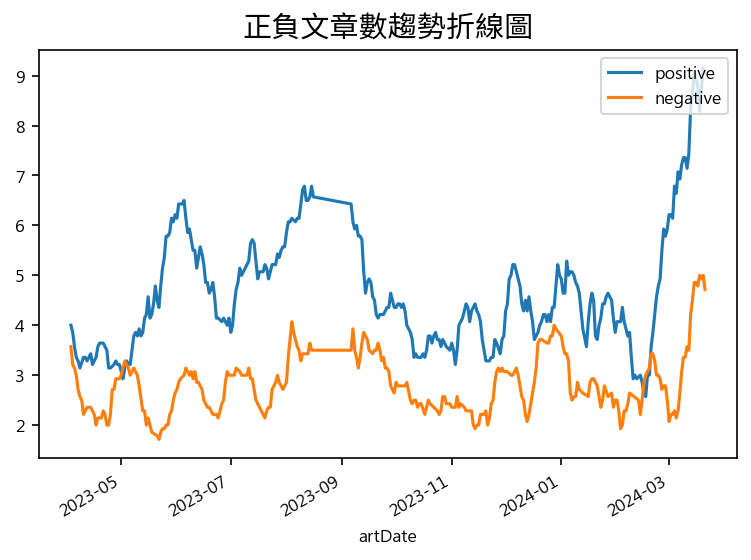

In [43]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_art_count[sentiment_art_count["sentiment_class"] == "正向"]
neg = sentiment_art_count[sentiment_art_count["sentiment_class"] == "負向"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])
# ax.plot(pos["artDate"], pos['size'], color=colors[0])
# ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負文章數趨勢折線圖", fontproperties=fprop)  # 記得加上才能顯示中文

### 情緒代表字

In [44]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

word sentiments  size
2191   風險   negative   879
2190   風險        anx   879
2189   風險     affect   879
2116   重要   positive   371
2115   重要     affect   371
...   ...        ...   ...
1742   細心   positive     1
997    抑鬱     affect     1
967    打擾   negative     1
966    打擾        anx     1
521    墮落   negative     1

[2265 rows x 3 columns]

In [45]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
2116   重要   positive   371
681    希望   positive   341
1001   投入   positive   311
288    分享   positive   311
70     不錯   positive   266
1630   相信   positive   226
1715   簡單   positive   221
2092   適合   positive   220
1692   積極   positive   193
1250   樂觀   positive   191
378    受惠   positive   190
638    容易   positive   188
1333   決定   positive   171
614    安全   positive   171
1665   確定   positive   168

In [46]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
2191   風險   negative   879
1908   虧損   negative   284
526    壓力   negative   215
2144   降低   negative   185
1922   衰退   negative   161
1111   擔心   negative   155
1082   損失   negative   154
489    嚴重   negative   126
1508   爆發   negative   111
726    強勢   negative   107
1915   衝擊   negative    94
200    債務   negative    91
1983   變動   negative    85
1064   控制   negative    85
950    戰爭   negative    82

C:\Users\james\AppData\Local\Temp\ipykernel_21004\1997491927.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop, fontsize=8)
C:\Users\james\AppData\Local\Temp\ipykernel_21004\1997491927.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop, fontsize=8)


Text(0.5, 1.0, '負向情緒總數')

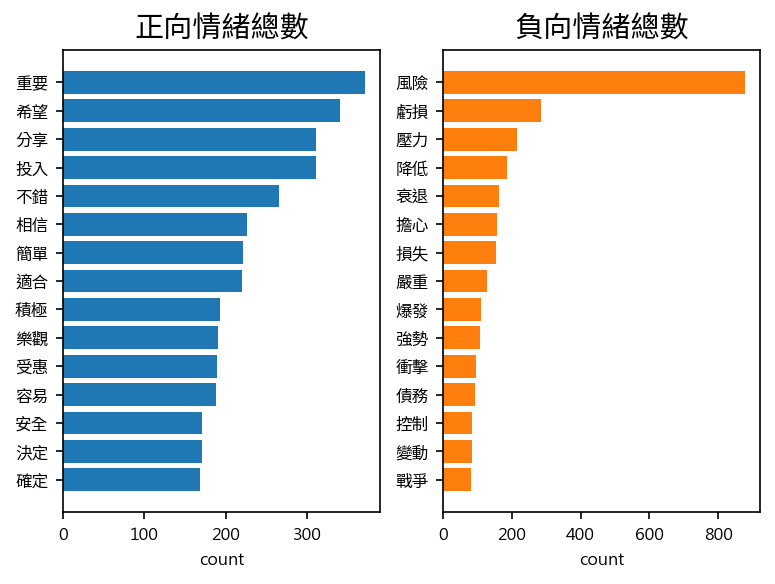

In [47]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop, fontsize=8)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop, fontsize=8)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

#### 重新計算情緒

投入、分享、問題、風險、降低、控制、衝擊、變動、強勢、智慧

In [48]:
# 設定要移除的字詞列表
words_to_remove = ['問題','分享','投入','風險','降低','控制','衝擊','變動', '強勢', '智慧', '重要']
# 使用 ~ 運算子和 isin() 方法過濾掉包含在 words_to_remove 列表中的行
liwc_dict_revise = liwc_dict[~liwc_dict['word'].isin(words_to_remove)]
# 使用更新後的情緒字典 merge
ptt_liwc_df_revise = pd.merge(nostop_df_updated[["artUrl", "artDate", "artTitle", "artContent","word"]], liwc_dict_revise, how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
2  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   

          artTitle                                         artContent    word  \
0  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      標的   
1  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...  2646TW   
2  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      星宇   
3  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      航空   
4  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      討論   

  sentiments  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

C:\Users\james\AppData\Local\Temp\ipykernel_21004\1652821560.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop, fontsize=8)
C:\Users\james\AppData\Local\Temp\ipykernel_21004\1652821560.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop, fontsize=8)


Text(0.5, 1.0, '負向情緒總數')

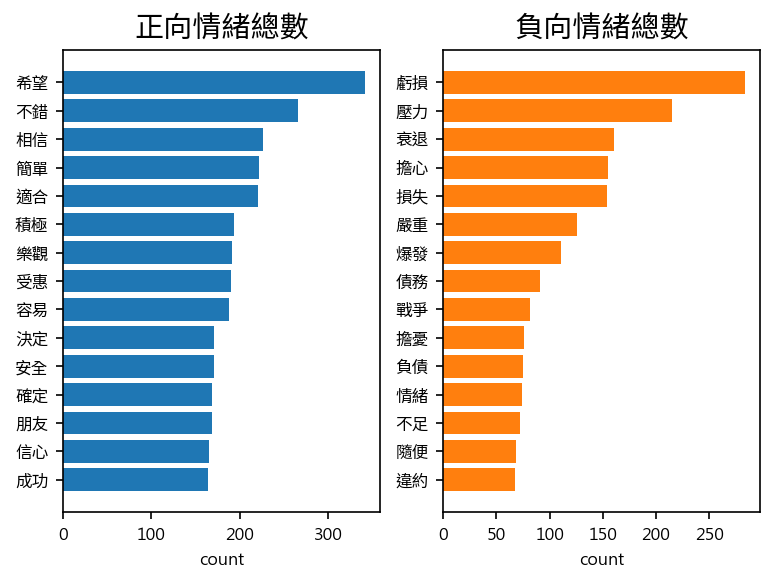

In [49]:
word_count = ptt_liwc_df_revise.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop, fontsize=8)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop, fontsize=8)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

重新繪製情緒分數趨勢圖

Text(0.5, 1.0, '正負情緒分數趨勢折線圖')

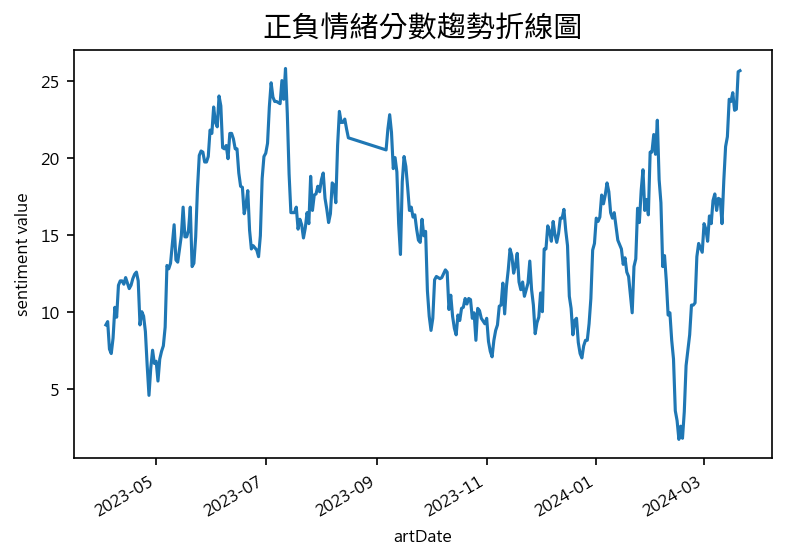

In [51]:
sentiment_count_revise = pd.DataFrame(
    ptt_liwc_df_revise.groupby(["artDate", "sentiments"]).size()
).reset_index()

mask = (sentiment_count_revise['sentiments'] == "positive") | (sentiment_count_revise['sentiments'] == "negative") 
sentiment_count_revise = sentiment_count_revise.loc[mask]

sentiment_count_revise = sentiment_count_revise.rename(columns={0: "size"})
sentiment_count_revise = sentiment_count_revise.sort_values(["artDate"])

ptt_sentiment_value_revise = (
    sentiment_count_revise.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# sentiment 計算方式: positive - negative
ptt_sentiment_value_revise["sentiment_value"] = (
    ptt_sentiment_value_revise["positive"]
    - ptt_sentiment_value_revise["negative"]
)

# 繪製情緒分數趨勢圖
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value_revise["artDate"], ptt_sentiment_value_revise["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()
plt.title("正負情緒分數趨勢折線圖", fontproperties=fprop)

### 文字雲

In [52]:
ptt_liwc_df_revise = pd.merge(ptt_liwc_df_revise, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
ptt_liwc_df_revise.head()

artUrl     artDate  \
0  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
2  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
3  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   
4  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...  2023-03-21   

          artTitle                                         artContent    word  \
0  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      標的   
1  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...  2646TW   
2  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      星宇   
3  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      航空   
4  [標的]星宇航空座艙科技點滿多  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...      討論   

  sentiments sentiment_class  
0        NaN             NaN  
1        NaN             NaN  
2        NaN             NaN  
3        NaN             NaN  
4        NaN             NaN

In [53]:
sent_df = pd.merge(sent_df, ptt_sentiment_value_by_article[['artUrl', 'sentiment_class']], how="left")
sent_df

artUrl           artTitle  \
0       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...    [標的]星宇航空座艙科技點滿多   
1       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...    [標的]星宇航空座艙科技點滿多   
2       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...    [標的]星宇航空座艙科技點滿多   
3       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...    [標的]星宇航空座艙科技點滿多   
4       https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...    [標的]星宇航空座艙科技點滿多   
...                                                   ...                ...   
130696  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  [請益]為什麼不是選期貨是選正二？   
130697  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  [請益]為什麼不是選期貨是選正二？   
130698  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  [請益]為什麼不是選期貨是選正二？   
130699  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  [請益]為什麼不是選期貨是選正二？   
130700  https://www.ptt.cc/bbs/Stock/M.1711019513.A.2C...  [請益]為什麼不是選期貨是選正二？   

                    artDate  \
0       2023-03-21 00:30:56   
1       2023-03-21 00:30:56   
2       2023-03-21 00:30:56   
3       2023-03-21 00:30:56   
4       2023-03-21 00:30:56   
...                     ...   
130696  2024-03-21 19:11:51   
130697  2024-03-21 19:11:51   
130698  2024-03-21 19:11:51   
130699  2024-03-21 19:11:51   
130700  2024-03-21 19:11:51   

                                               artContent  \
0       1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1       1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
2       1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
3       1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
4       1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
...                                                   ...   
130696  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
130697  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
130698  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
130699  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   
130700  我比較了一下同樣的投資金額\n\n期貨的表現遠遠高於正二，以下請看\n\n假設最低點121....   

                    sentence sentiment_class  
0       1 標的      2646TW星宇航空             NaN  
1                     2 分類討論             NaN  
2                     3 分析正文             NaN  
3               剛剛看到3C頻道邦尼幫你             NaN  
4              測試星宇的經濟艙有什麼東西             NaN  
...                      ...             ...  
130696                  以下請看             NaN  
130697       假設最低點1215進場344股             NaN  
130698               共41796元             NaN  
130699             最高點位是1943             NaN  
130700             這樣賺了25043             NaN  

[130701 rows x 6 columns]

In [54]:
mask = (ptt_liwc_df_revise['sentiment_class'] == "負向")
ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]


word_count_count = pd.DataFrame(
    ptt_df_wc.groupby(["word"]).size()
).reset_index().rename(columns={0: "size"})
word_count_count = word_count_count.sort_values(by='size', ascending=False)
word_count_count

word  size
14337            投資   970
6241             中國   754
12654            市場   740
20728            美國   715
3454            ETF   661
...             ...   ...
14753            控由     1
4539   YANGNYSEARCA     1
14757           推一個     1
4538           YANG     1
26476            龜速     1

[26477 rows x 2 columns]

(-0.5, 399.5, 199.5, -0.5)

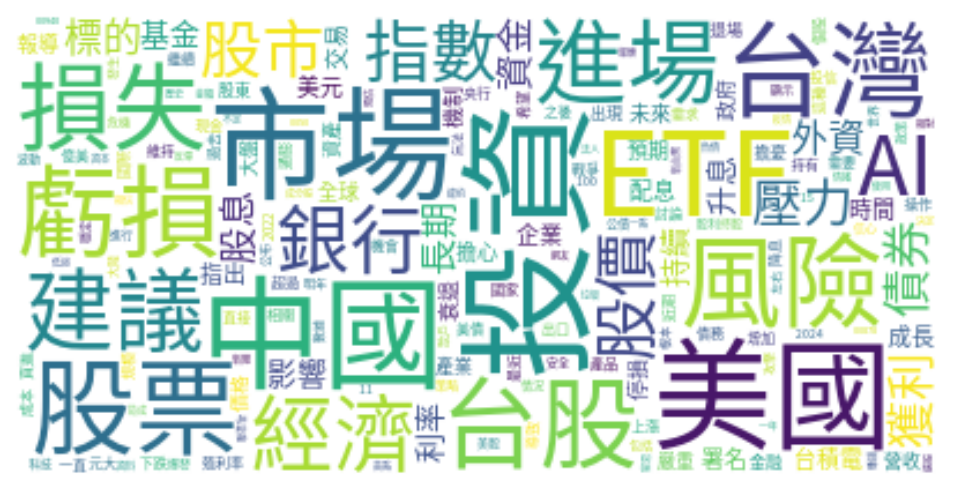

In [55]:
# wordcloud 的 input 是 dictionary
font_path = "./data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
wc_dict = dict(zip(word_count_count['word'], word_count_count['size']))
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc_dict)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

探討台積電負面的詞彙

(-0.5, 399.5, 199.5, -0.5)

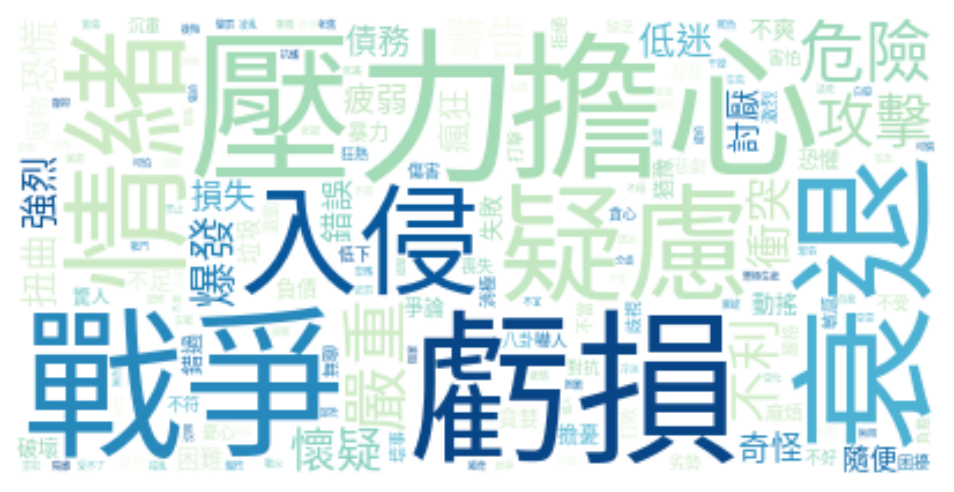

In [56]:
mask = (ptt_liwc_df_revise['sentiment_class'] == "負向")  & ( # 負面文章
    ptt_liwc_df_revise['artContent'].str.contains('台積電')) & ( # 內文包含AI
    ptt_liwc_df_revise["sentiments"] == "negative") # 負面情緒字

ptt_df_wc = ptt_liwc_df_revise.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()

# wordcloud 的 input 是 dictionary
font_path = "./data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

去看他們覺得台積電甚麼恐怖

In [57]:
mask = (sent_df['sentiment_class'] == "負向") & (
    sent_df['artContent'].str.contains('台積電')) & (
    sent_df['sentence'].str.contains('恐怖')) # 包含「擔心」的句子

df_ = sent_df.loc[mask, ["artDate", "artContent", "sentence"]]
index_list = df_.index.tolist()


# 取得前後各5筆的索引 => 目的為查看包含該詞彙句子的上下文
surrounding_indices = []
for index in index_list:
    surrounding_indices.extend(range(index - 5, index + 6))

# 去除重複的索引，並確保不超出範圍
surrounding_indices = list(set(filter(lambda x: x >= 0 and x < len(sent_df), surrounding_indices)))

# 依據索引取得相應的資料
result_df = sent_df.iloc[surrounding_indices].sort_index()
result_df.head(20)

artUrl  \
51773  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51774  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51775  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51776  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51777  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51778  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51779  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51780  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51781  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51782  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   
51783  https://www.ptt.cc/bbs/Stock/M.1690968723.A.D8...   

                     artTitle              artDate  \
51773  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51774  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51775  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51776  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51777  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51778  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51779  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51780  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51781  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51782  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   
51783  [新聞]獨家／台股重挫主因曝！超導體難救市專  2023-08-02 17:31:52   

                                              artContent        sentence  \
51773  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...          這就比較不妙   
51774  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...      加上現在很多當沖過熱   
51775  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...           比例非常高   
51776  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...        還有人做個股期貨   
51777  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...  能用一口45萬的資金開高槓桿   
51778  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...        比融資當沖還恐怖   
51779  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...           現在很多年   
51780  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...           輕人做這個   
51781  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...           只好修理了   
51782  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...      多頭一起賺空頭一起死   
51783  原文標題：獨家／台股重挫主因曝！超導體難救市 專家看好AI復活：2指標出現快買\n\n原文連...             連環爆   

      sentiment_class  
51773              負向  
51774              負向  
51775              負向  
51776              負向  
51777              負向  
51778              負向  
51779              負向  
51780              負向  
51781              負向  
51782              負向  
51783              負向

### 利用CKIP進行自然語言處理

In [58]:
# 將三份工具的模型路徑指向我們剛才下載的檔案「data」
ws = WS("./data")
pos = POS("./data")
ner = NER("./data")

c:\Users\james\anaconda3\lib\site-packages\ckiptagger\model_ws.py:106: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\james\anaconda3\lib\site-packages\ckiptagger\model_pos.py:56: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)
c:\Users\james\anaconda3\lib\site-packages\ckiptagger\model_ner.py:57: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.LSTMCell(hidden_d, name=name)


In [59]:
# 由於工作流程平台資料筆數上限為10000，所以我們分三個檔案下載
df = pd.read_csv('data/Stock_data_fresh.csv')
df.head(5)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Stock/M.1679329858.A.0A...   
1          2  https://www.ptt.cc/bbs/Stock/M.1679357023.A.F6...   
2          3  https://www.ptt.cc/bbs/Stock/M.1679357673.A.3A...   
3          4  https://www.ptt.cc/bbs/Stock/M.1679362380.A.A3...   
4          5  https://www.ptt.cc/bbs/Stock/M.1679364597.A.3B...   

                        artTitle              artDate  artPoster artCatagory  \
0                [標的]星宇航空座艙科技點滿多  2023-03-21 00:30:56  enouch777       Stock   
1  Re:[標的]潤泰全2915潤泰新9945反彈肉最少10%  2023-03-21 08:03:41     YU1225       Stock   
2      Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 08:14:29    peter98       Stock   
3      Re:[請益]線仙能靠技術分析全職操盤穩定獲利嗎?  2023-03-21 09:32:58     YukiTW       Stock   
4      [新聞]外資大砍金融股！中信金遭賣15.73萬張最  2023-03-21 10:09:52    allfate       Stock   

                                          artContent  \
0  1. 標的：      2646.TW星宇航空\n\n2. 分類：討論\n\n3. 分析/正...   
1  今天沒意外準備反彈 、\n南山人壽已經澄清部位非常少\n股價根本過度反應 反彈最少10%\n...   
2  技術分析的問題是  公說公有理  婆說婆有理\n\n你一旦說他沒道理  就有屁孩會來跟你說是...   
3  有一招技術分析，你可能聽過，\n就是創新高的股票，上無壓力，會繼續延伸氣勢，\n簡單來說，就...   
4  原文標題：\n\n外資大砍金融股！中信金遭賣15.73萬張最慘 新光金、玉山金同步遭砍\n原...   

                                          artComment             e_ip  \
0  [{"cmtStatus": "推", "cmtPoster": "devidevi", "...  111.184.170.175   
1  [{"cmtStatus": "推", "cmtPoster": "sdhpipt", "c...    106.1.120.140   
2  [{"cmtStatus": "推", "cmtPoster": "Altair", "cm...   73.195.162.171   
3  [{"cmtStatus": "推", "cmtPoster": "slayptter", ...   101.136.205.85   
4  [{"cmtStatus": "→", "cmtPoster": "sexybox", "c...    42.79.171.144   

          insertedDate dataSource  
0  2023-03-21 02:21:56        ptt  
1  2023-03-22 02:22:39        ptt  
2  2023-03-22 02:22:39        ptt  
3  2023-03-22 02:22:39        ptt  
4  2023-03-22 02:22:39        ptt

In [60]:
def Segmentation_Core(data, tokenizer):
    # 將所有的斷行字元配上 escape 以防失效
    regexPattern = '|'.join(map(re.escape, tokenizer))
    output_list = re.split(regexPattern, data)
    # 過濾空白行
    output_list = list(filter(None, output_list))
    return output_list

def Sentence_Segmentation(article, keep_digits=False, keep_alphabets=False):
    """ Sentence_Segmentation function 用於執行中文斷行任務

    順序如下：
    1. 去除(\\n)
    2. 去除特殊符號字元
    3. 保留數字
    4. 依照斷句字元進行斷句全形的分號、逗號、句號、問號以及驚嘆號
    5. 避免空白斷句結果

    Args:
        article(string): 欲斷行之文章內容
        keep_digits(Boolean): 決定是否保留數字於斷行後的結果
        keep_alphabets(Boolean): 決定是否保留字母於斷行後的結果
    Returns:
        List [] 每個 element 就是一行
    """
    sepical_symbols = r'[.＂<>:《》+\-=#$%&()*@＃＄％＆＇\(\)\[\]\{\}（）＊＋－／：\
    ＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—一‘’‛“”„‟…‧﹏★→─]+'
    segmentation_used_note = (";", "；", "！", "!", "？", "?", "。")
    

    paragraphs = list(filter(lambda x: re.sub(r'\s+','', x), article.split("\n")))
    # print(len(paragraphs))
    # print(paragraphs)
    
    result = []
    for paragraph in paragraphs:

        clean_paragraph = paragraph
        try:
            if not keep_digits:
                clean_paragraph = re.sub(r'\d*\.?\d+','', clean_paragraph) #remove space & digits
            if not keep_alphabets:
                clean_paragraph = re.sub('[a-zA-Z]+', '', clean_paragraph)
            
            clean_paragraph = re.sub(r'[\s]+','', clean_paragraph) #remove space
            
            clean_paragraph = re.sub(sepical_symbols,'',clean_paragraph)
            
        except:
            return "error"
        
        res = Segmentation_Core(clean_paragraph, segmentation_used_note)
        result.append(res)
    
    return result

CKIP 處理相關function

In [61]:
# 自定義辭典
with open('dict/user_dict.txt') as f:
    lines = f.read().splitlines()

dict = {k.split()[0]: k.split()[1] for v, k in enumerate(lines)}
dictionary2 = construct_dictionary(dict)
print(dictionary2)

[(2, {'證券': 500.0, '股瞟': 500.0, '上市': 500.0, '上櫃': 500.0, '除息': 500.0, '除權': 500.0, '填息': 500.0, '填權': 500.0, '交割': 500.0, '融資': 500.0, '融券': 500.0, '溢價': 500.0, '折價': 500.0, '多頭': 500.0, '空頭': 500.0, '放空': 500.0, '作手': 500.0, '買超': 500.0, '賣超': 500.0, '套牢': 500.0, '軋空': 500.0, '補空': 500.0, '坐轎': 500.0, '下轎': 500.0, '牛市': 500.0, '熊市': 500.0, '斷頭': 500.0, '探底': 500.0, '築底': 500.0, '跳空': 500.0, '補漲': 500.0, '反彈': 500.0, '回檔': 500.0, '回跌': 500.0, '看淡': 500.0, '利多': 500.0, '利空': 500.0, '歐印': 500.0, '呆股': 250.0, '外豬': 250.0, '小兒': 250.0, '號子': 250.0, '捷哥': 250.0, '頭痛': 250.0, '多多': 250.0, '空空': 250.0, '多蛙': 100.0, '空蛙': 100.0, '凹單': 250.0, '猜頂': 250.0, '摸頭': 250.0, '摸底': 250.0, '抬轎': 250.0, '甩轎': 250.0, '韭菜': 250.0}), (3, {'開盤價': 500.0, '收盤價': 500.0, 'EPS': 500.0, '本益比': 500.0, '台GG': 250.0, '永動積': 250.0, '海公公': 250.0, '紅茶店': 250.0}), (4, {'集中市場': 500.0, '店頭市場': 500.0, '當日沖銷': 500.0, '信用交易': 500.0, '利多出盡': 500.0, '全額交割': 100.0, '基本分析': 100.0, '技術分析': 100.0, '護國神山': 500.0, '面板雙虎': 250.0, '股市

In [62]:
def get_pos(post_id, word_sentence, pos_sentence):
    tokens = []
    # print("\nPOS: ", end="\u3000")
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence): # token level
        tokens.append([post_id, word, pos]) 
    # print(f"{word}({pos})", end="\u3000")
    return tokens

def get_ner(post_id, entity_sentence):
    entities = []
    # print("\nNER:___________ ")
    for entity in sorted(entity_sentence): # token level
        entities.append([post_id, entity[3], entity[2]]) 
    return entities

def get_nlp_result(data_df):
    start = time.time()

    pos_list = []
    entity_list = []
    sentence_list = []
    
    # 遍歷 dataframe 的每筆資料
    for index, row in data_df.iterrows(): # document level    
    # print(f"\ndocument {index}") 

        # 資料清理 ＆ 斷句
        tmp = Sentence_Segmentation(row['artContent']) 
        flat_list = [item for sublist in tmp for item in sublist]

        # ckip
        word_sentence_list = ws(flat_list, coerce_dictionary = dictionary2)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)

        # 遍歷該 document 中的每一個句子
        for i, sentence in enumerate(flat_list):
            # print(f"sentence {i}: {sentence}")
            sentence_list.append([row['system_id'], sentence])            
            temp_tokens = get_pos(row['system_id'], word_sentence_list[i], pos_sentence_list[i])
            temp_entites = get_ner(row['system_id'], entity_sentence_list[i])

            pos_list.append(temp_tokens)
            if len(temp_entites) != 0:
                entity_list.append(temp_entites)
            
    pos_flat = [item for sublist in pos_list for item in sublist]
    entity_flat = [item for sublist in entity_list for item in sublist]

    pos_table = pd.DataFrame(data=pos_flat, 
                    columns=['system_id','word','pos'])        
    
    entity_table = pd.DataFrame(data=entity_flat, 
                        columns=['system_id','word','ner']) 

    sentence_table = pd.DataFrame(data=sentence_list, 
                    columns=['system_id','sentence']) 

    end = time.time()
    print("time costing: {}".format(end - start))

    return pos_table, entity_table, sentence_table

In [63]:
pos_table, entity_table, sentence_table = get_nlp_result(df)

time costing: 2980.371520280838


In [64]:
pos_table.head() # word pos 列表

system_id word pos
0          1   標的  Na
1          1   星宇  Nb
2          1   航空  Na
3          1   分類  Na
4          1   討論  VE

In [65]:
entity_table.head() # word entity 列表

system_id  word     ner
0          1  星宇航空     ORG
1          1    邦尼  PERSON
2          1    星宇  PERSON
3          1    二月    DATE
4          1   峇厘島     LOC

In [66]:
sentence_table.head()

system_id       sentence
0          1         標的星宇航空
1          1           分類討論
2          1          分析/正文
3          1     剛剛看到頻道邦尼幫你
4          1  測試星宇的經濟艙有什麼東西

In [67]:
# 檢查筆數
print(f"total posts numbers: {len(pos_table['system_id'].unique())}") # 551篇文
print(f"posts have NER: {len(entity_table['system_id'].unique())}") # 524篇有抓到ner

total posts numbers: 2867
posts have NER: 2769


In [68]:
# 將文章存成csv
# pos_table.to_csv('data/pos_table_stock_fresh.csv', index = False)
# entity_table.to_csv('data/entity_table_stock_fresh.csv', index = False)
# sentence_table.to_csv('data/sentence_table_stock_fresh.csv', index = False)

### 探索分析 - NER

In [ ]:
# 讀取已經執行完畢的結果
# pos_table = pd.read_csv("raw_data/zh/pos_table_buffet.csv") 
# entity_table = pd.read_csv("raw_data/zh/entity_table_buffet.csv") 
# sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") 

### NER 種類分析

In [69]:
entity_table['ner'].unique()

array(['ORG', 'PERSON', 'DATE', 'LOC', 'FAC', 'TIME', 'GPE', 'PRODUCT',
       'CARDINAL', 'LANGUAGE', 'WORK_OF_ART', 'MONEY', 'ORDINAL', 'NORP',
       'PERCENT', 'EVENT', 'LAW', 'QUANTITY'], dtype=object)

In [70]:
ner_count = entity_table.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

ner  count
11       ORG  13906
1       DATE  13125
4        GPE   8373
13    PERSON   8016
0   CARDINAL   4937
8      MONEY   2360
10   ORDINAL   1516
9       NORP   1444
7        LOC    865
16      TIME    609

C:\Users\james\AppData\Local\Temp\ipykernel_21004\3390866936.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


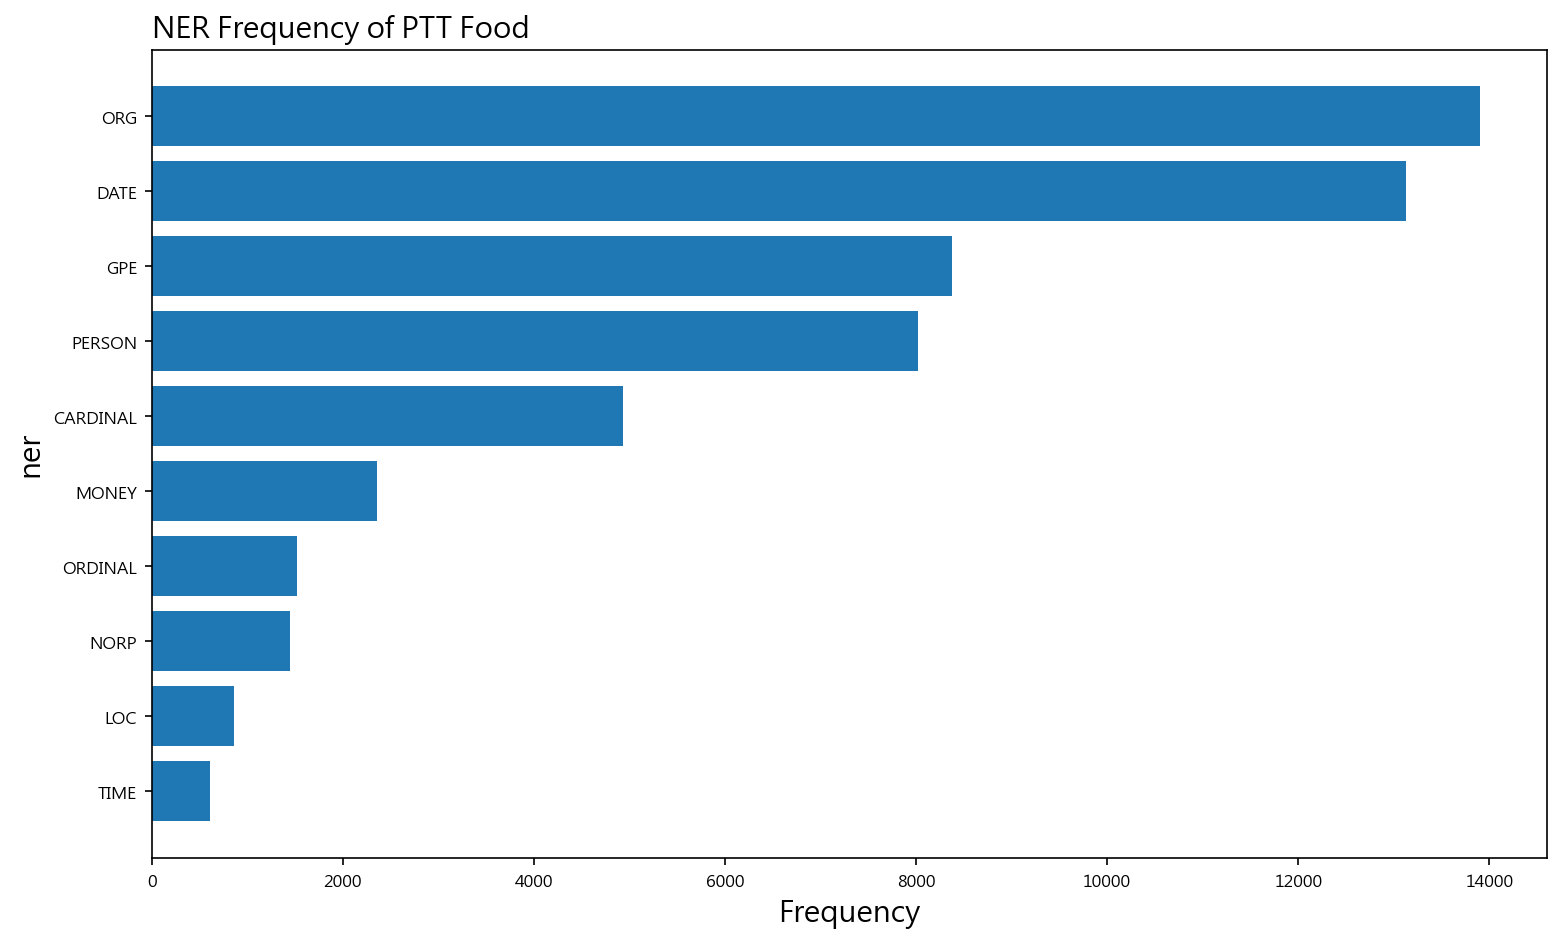

In [71]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('NER Frequency of PTT Food',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到公司、組織(ORG)

C:\Users\james\AppData\Local\Temp\ipykernel_21004\2048892580.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif

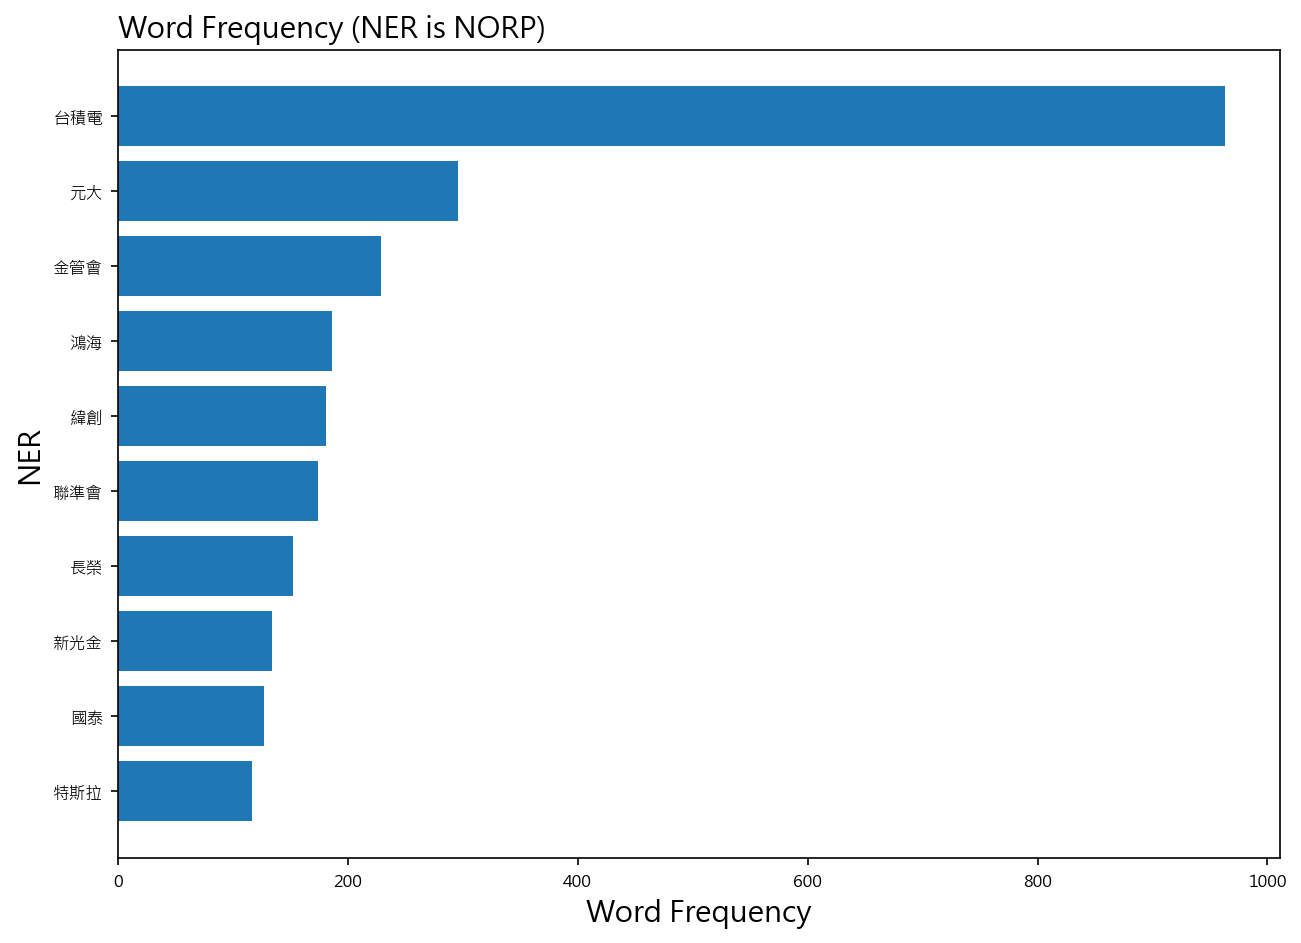

In [72]:
# 篩選ner為NORP的資料
l_noun = ["ORG"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到PTT的股票版近一個禮拜大多討論台積電、元大、鴻海

### 涉及到的人物(PERSON)

C:\Users\james\AppData\Local\Temp\ipykernel_21004\3760592606.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

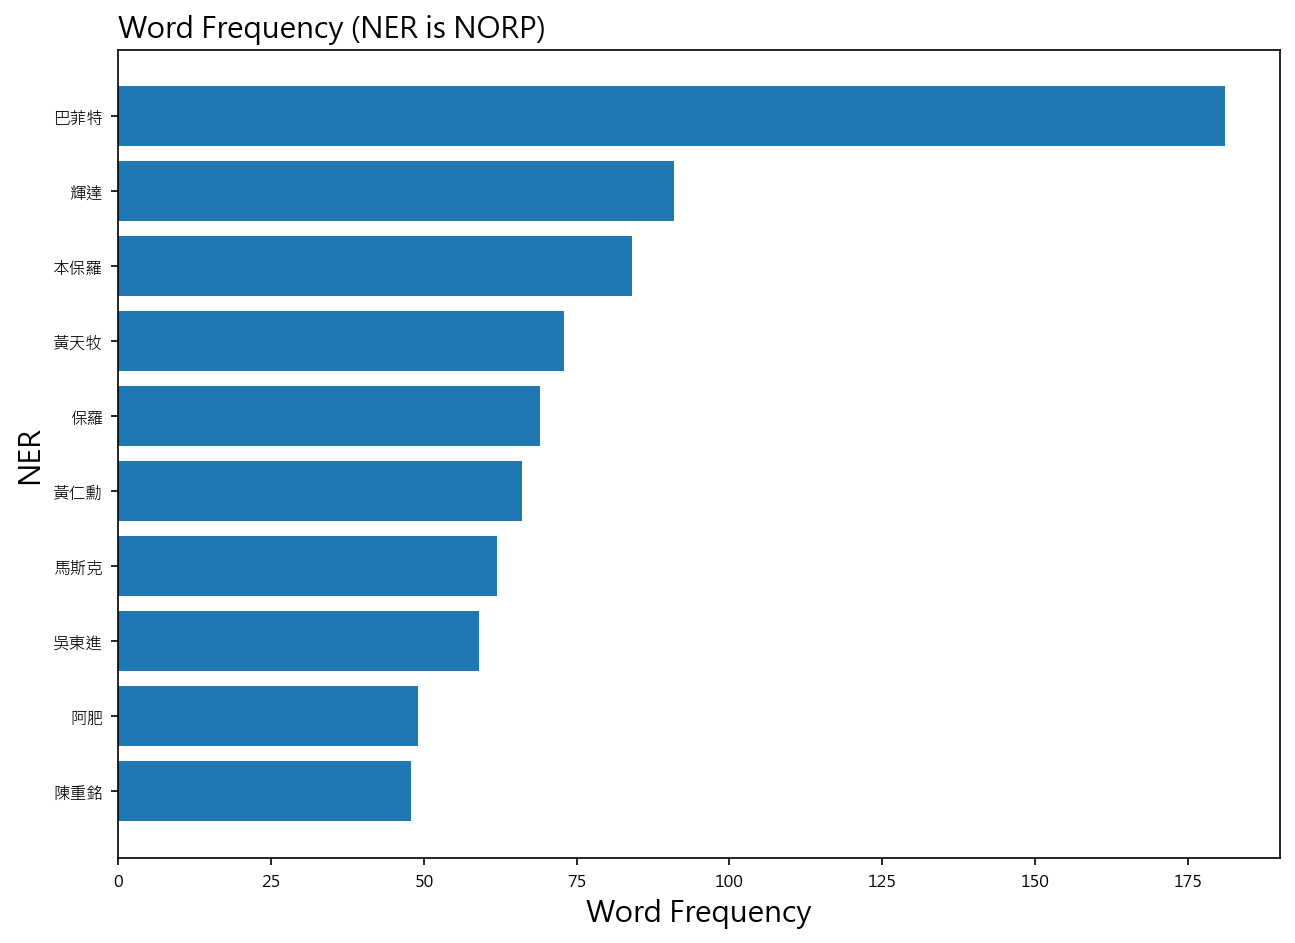

In [73]:
# 篩選ner為NORP的資料
l_noun = ["PERSON"]
NORP = entity_table[entity_table.ner.isin(l_noun)]

# # 計算每個名詞提到的次數，選出前10個
ner_count = NORP.groupby('word')['word'].agg(['count'])
ner_count = ner_count.sort_values(['count'],ascending=False)['count'].nlargest(10).reset_index()
ner_count

# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = ner_count['word']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is NORP)',loc ='left', size = 14)
ax.set_ylabel('NER', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

In [74]:
keyword_list = ['台積電']
shu_selected = df[df['artContent'].str.contains('|'.join(keyword_list),regex=True)]
print(f"{' '.join(keyword_list)}：{shu_selected.shape[0]}篇相關貼文")
shu_selected.head(3)

台積電：422篇相關貼文


system_id                                             artUrl  \
11         12  https://www.ptt.cc/bbs/Stock/M.1679403117.A.81...   
15         16  https://www.ptt.cc/bbs/Stock/M.1679455485.A.B1...   
16         17  https://www.ptt.cc/bbs/Stock/M.1679457400.A.92...   

               artTitle              artDate   artPoster artCatagory  \
11          Re:[標的]持股健檢  2023-03-21 20:51:45     koko147       Stock   
15          Re:[標的]持股健檢  2023-03-22 11:24:36       tompi       Stock   
16  [新聞]還在升息「台股怎麼全面樂觀」？  2023-03-22 11:56:38  bruce20053       Stock   

                                           artContent  \
11  老韭菜借文討論\n主要健檢原因是\n想賣部份股票來湊足開支需求\n不知道賣什麼好故貼上持股請...   
15  如果有資金需求需賣股票，可以把比較沒效率的股票賣掉\n\n至於要買些股票，我提供一點我的計算...   
16  原文標題：\n\n還在升息「台股怎麼全面樂觀」？專家：只是反應台積電ADR漲點\n\n原文連...   

                                           artComment           e_ip  \
11  [{"cmtStatus": "→", "cmtPoster": "allgood123",...  61.224.88.118   
15  [{"cmtStatus": "推", "cmtPoster": "yuen1029", "...  114.37.122.88   
16  [{"cmtStatus": "噓", "cmtPoster": "m4vu0", "cmt...   49.217.3.235   

           insertedDate dataSource  
11  2023-03-22 02:22:49        ptt  
15  2023-03-23 02:22:22        ptt  
16  2023-03-23 02:22:22        ptt

### 探索分析 - POS

In [75]:
pos_table['pos'].unique()

array(['Na', 'Nb', 'VE', 'VC', 'FW', 'D', 'P', 'Nh', 'DE', 'V_2', 'Nep',
       'VG', 'COMMACATEGORY', 'Cbb', 'VCL', 'Dfa', 'VH', 'VK', 'Da', 'VD',
       'VJ', 'Nd', 'Nc', 'A', 'Nf', 'SHI', 'VA', 'Di', 'T', 'VF', 'Ng',
       'VHC', 'Neu', 'Nes', 'VL', 'I', 'Neqa', 'Ncd', 'VB', 'Caa', 'Cba',
       'Nv', 'Cab', 'VAC', 'Dk', 'VI', 'COLONCATEGORY', 'Dfb', 'Neqb',
       'DM', 'PERIODCATEGORY', 'PARENTHESISCATEGORY', 'ETCCATEGORY',
       'DASHCATEGORY'], dtype=object)

In [76]:
pos_filter = pos_table[~pos_table.pos.isin(['COMMACATEGORY', 'PARENTHESISCATEGORY', 'PERIODCATEGORY', 'COLONCATEGORY'])]

pos_count = pos_filter.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(12)
pos_count

pos   count
17  Na  209096
5    D   91960
37  VC   70371
43  VH   59423
7   DE   33656
31   P   33030
19  Nc   31797
21  Nd   23499
40  VE   23176
34  VA   22837
27  Nf   22775
18  Nb   22425

C:\Users\james\AppData\Local\Temp\ipykernel_21004\2478466374.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif

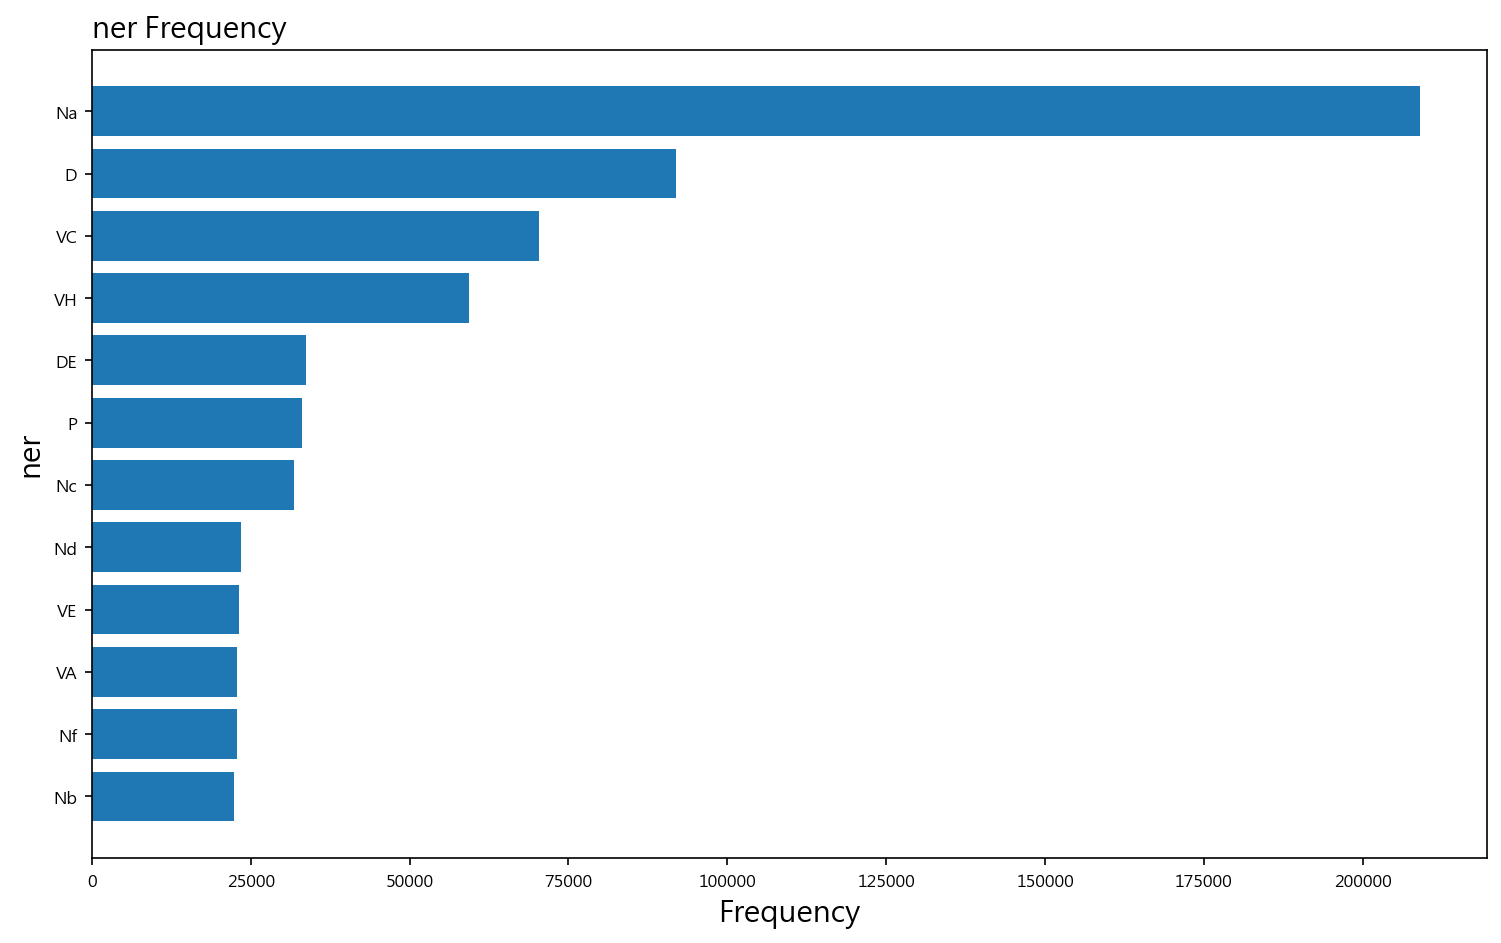

In [77]:
pos = pos_count['pos']
count = pos_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

### 涉及到的普通名詞(Nb)

In [80]:
# 篩選pos為專有名詞的資料
l_noun = ["Nb"] #,"Na"
noun = pos_table[pos_table.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

word  count
637   台積電   1104
321    元大    541
4288   長榮    447
885    國泰    374
1424    張    334
4736   鴻海    302
3153   緯創    269
1308  巴菲特    204
3226   群益    194
3930   輝達    189

C:\Users\james\AppData\Local\Temp\ipykernel_21004\502700507.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

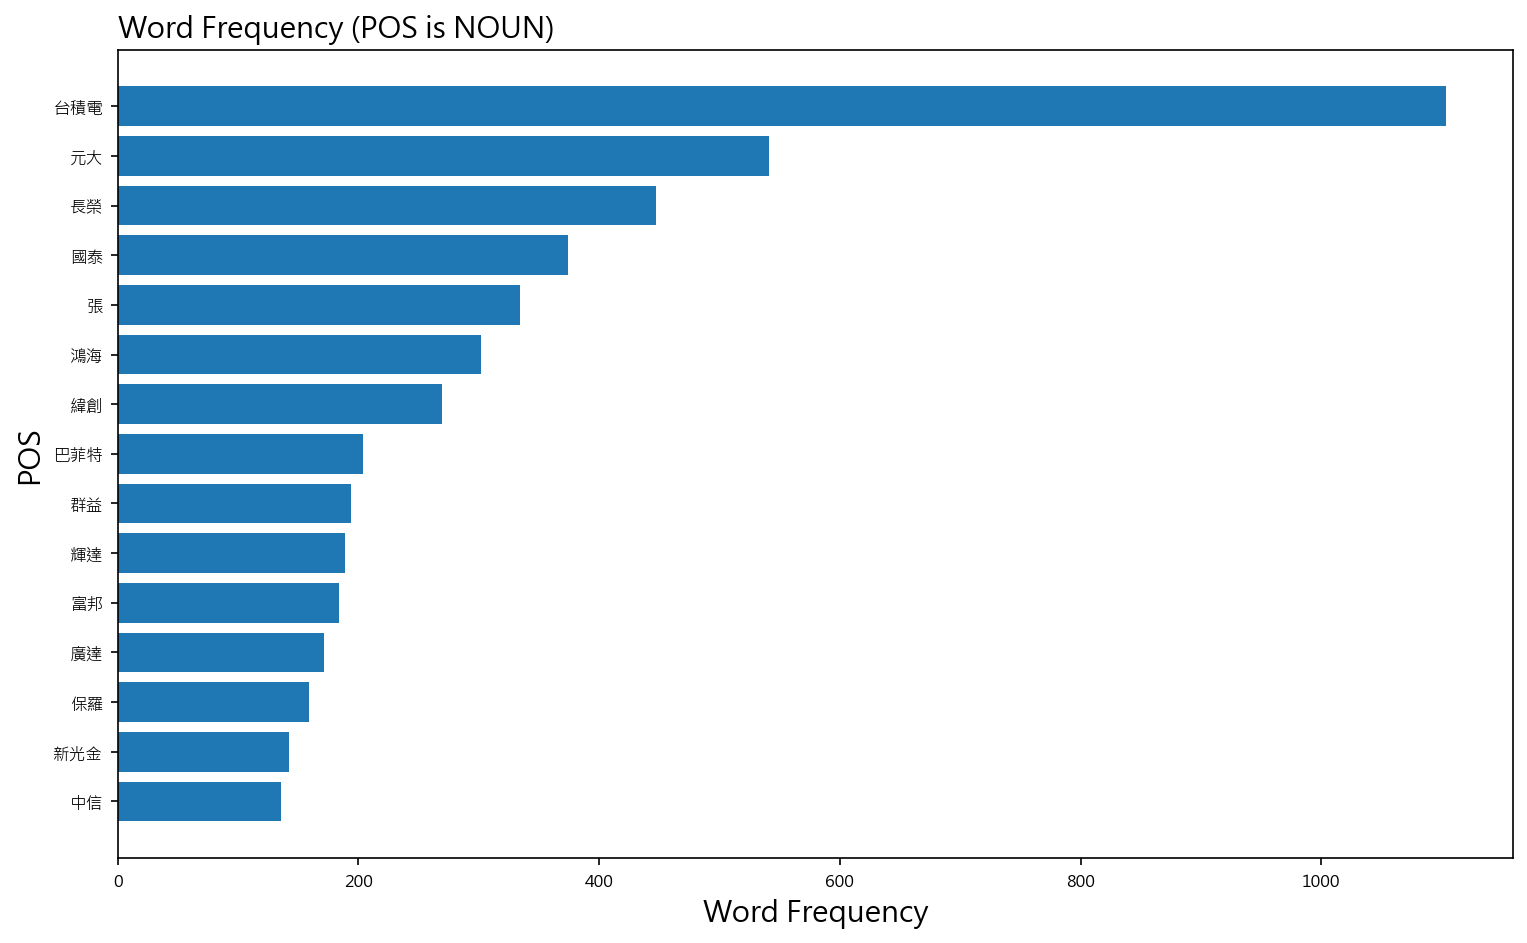

In [81]:
# 設定中文字形
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NOUN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

可以看到台積電依舊市最多討論度的，果然是護國神山！！

### 涉及到的動詞(VERB)

In [82]:
l_verb = ["VH"] # ,"VH","VA"
verb = pos_table[pos_table.pos.isin(l_verb)] # 選取特定詞性
verb = verb[verb['word'].map(len) > 1] # 把長度為1的字去除掉

verb_count = verb[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
verb_count

word  count
364    停損    882
1769   成長    869
2667   獲利    830
3812   這樣    725
2826   相關    637
16     上市    539
23     上漲    509
536    出現    494
2798   直接    475
3939   重要    427
2816   相對    417
39     下跌    411
1431   平均    374
158    不錯    328
1951   明顯    298

C:\Users\james\AppData\Local\Temp\ipykernel_21004\2587760616.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

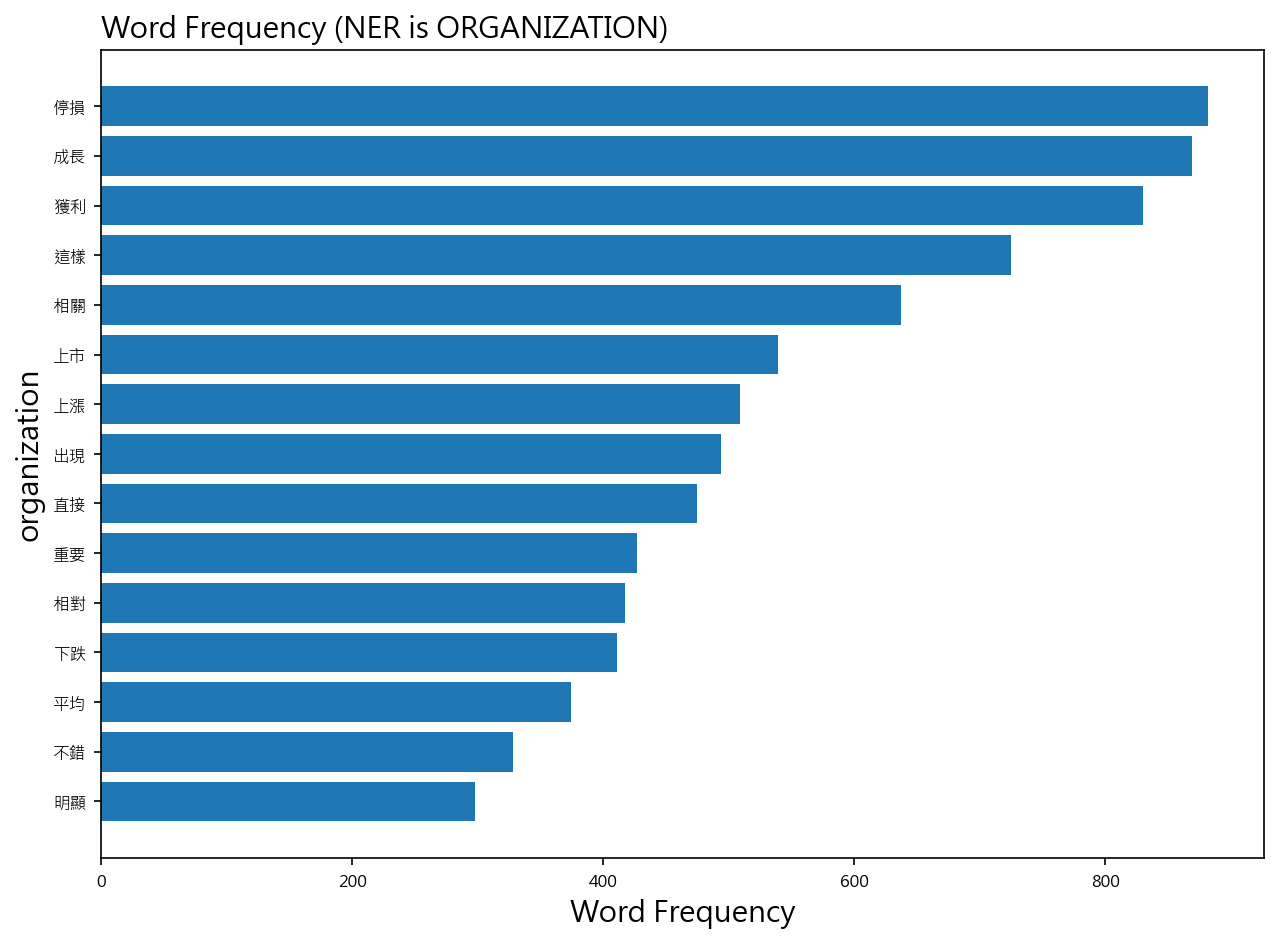

In [83]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = verb_count['word']
count = verb_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

### 利用SnowNLP進行情緒分析

In [84]:
from snownlp import SnowNLP
s = SnowNLP('這部電影很讚')
s.sentiments # 範圍在 0~ 1之間 (負面~正面)

0.786074481210413

In [85]:
# sentence_table = pd.read_csv("raw_data/zh/sentence_table_buffet.csv") #匯資料

sentiment_date = pd.merge(sentence_table,shu_selected[['system_id','artDate','dataSource']],on='system_id',how='left').dropna()
sentiment_date.head(3)

system_id       sentence              artDate dataSource
279         12        老韭菜借文討論  2023-03-21 20:51:45        ptt
280         12        主要健檢原因是  2023-03-21 20:51:45        ptt
281         12  想賣部份股票來湊足開支需求  2023-03-21 20:51:45        ptt

In [86]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row : get_sentiment(row['sentence'],), axis = 1)
sentiment_date.head(3)

system_id       sentence              artDate dataSource  sentimentValue
279         12        老韭菜借文討論  2023-03-21 20:51:45        ptt        0.612394
280         12        主要健檢原因是  2023-03-21 20:51:45        ptt        0.629852
281         12  想賣部份股票來湊足開支需求  2023-03-21 20:51:45        ptt        0.287884

In [87]:
# 看一下情緒的分布
sentiment_date['sentimentValue'].describe()

count    1.620100e+04
mean     3.641071e-01
std      3.111265e-01
min      6.825873e-12
25%      7.108666e-02
50%      2.571828e-01
75%      5.969402e-01
max      9.999999e-01
Name: sentimentValue, dtype: float64

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

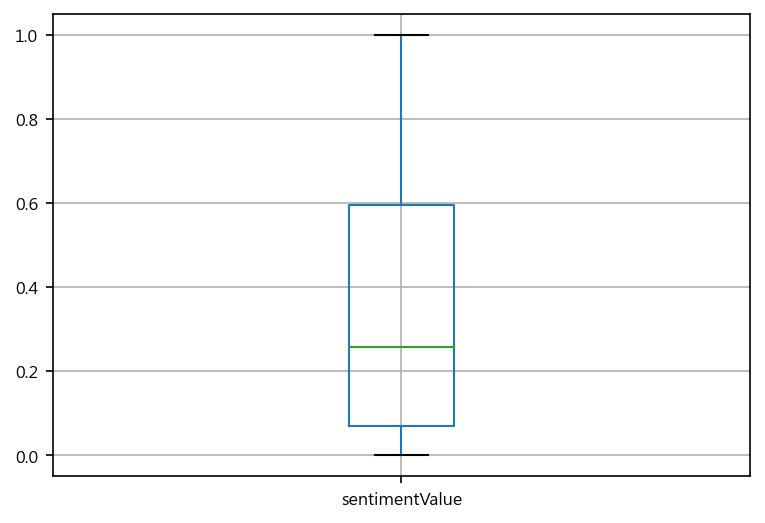

In [88]:
# 情緒分布的盒狀圖
boxplot = sentiment_date.boxplot(column=['sentimentValue'], showfliers=False)
boxplot

In [90]:
sent_date = sentiment_date.copy()
sent_date['artDate'] =  pd.to_datetime(sentiment_date['artDate']).dt.to_period('M')

sentiment_count = sent_date.groupby(['artDate'])['sentimentValue'].mean().reset_index()
sentiment_count

artDate  sentimentValue
0   2023-03        0.376301
1   2023-04        0.357227
2   2023-05        0.378405
3   2023-06        0.361441
4   2023-07        0.349635
5   2023-08        0.333254
6   2023-09        0.345444
7   2023-10        0.367919
8   2023-11        0.386215
9   2023-12        0.368354
10  2024-01        0.374850
11  2024-02        0.368174
12  2024-03        0.364746

C:\Users\james\AppData\Local\Temp\ipykernel_21004\857956447.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


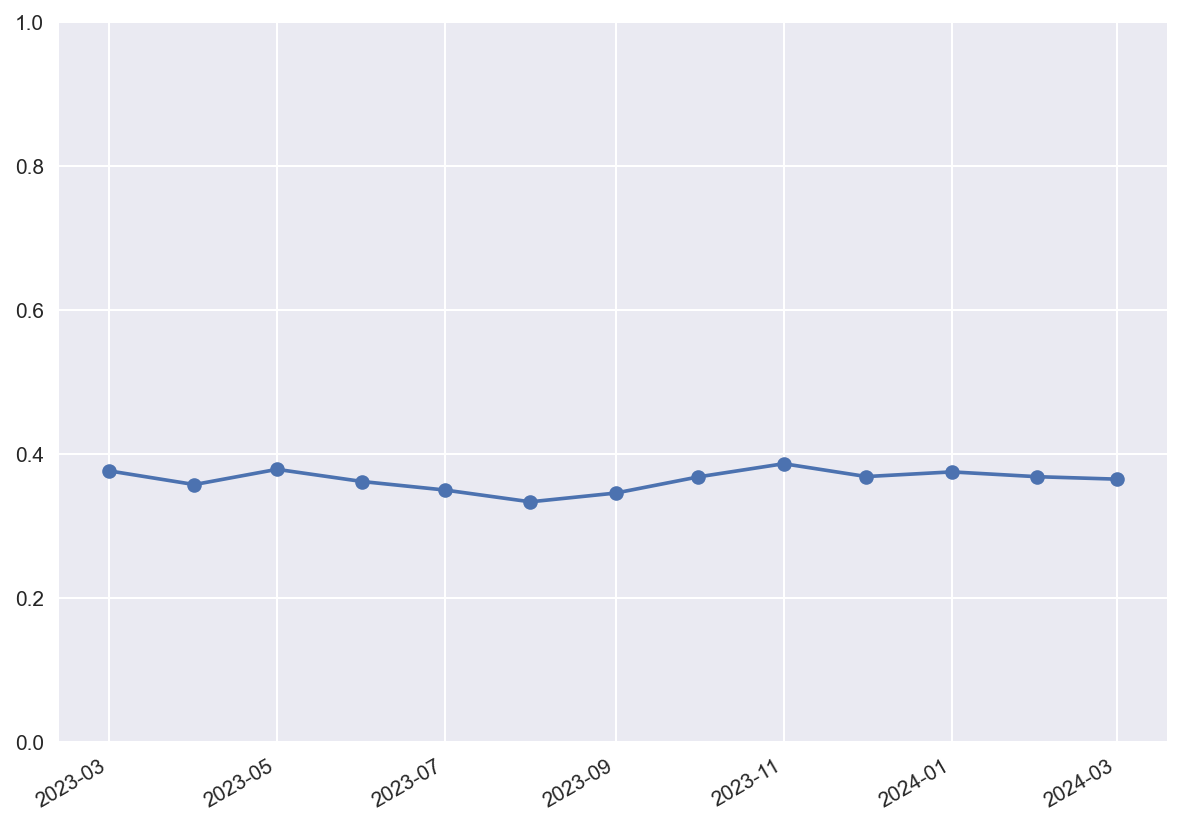

In [91]:
# 平均情緒分數時間趨勢
months = [period.to_timestamp() for period in sentiment_count['artDate']]   # 將 PeriodIndex 中的每個 Period 物件轉換為對應的 datetime 物件
y = sentiment_count['sentimentValue']

plt.style.use('seaborn')

plt.plot_date(months, y, linestyle='solid')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.ylim(0, 1)

plt.show()

從上圖中發現大部分天數的情緒值都在0.4~0.5之間，偏向中性，推測是因為PTT股票板上多數為請教投資相關問題的緣故。

### 詞彙探索
從上圖中可以發現 2024年3月19日的情緒分數相對高，我們把這天的正面句子挑出來看看他們都用甚麼詞。

In [92]:
# 篩時間
filter_sentiment = sent_date[sent_date['artDate']=='2024-03-19']
filter_sentiment = filter_sentiment.loc[filter_sentiment['sentimentValue'] > 0.7]

filter_sentiment.head()

system_id                                sentence  artDate dataSource  \
83119       2526                                   分析/正文  2024-03        ptt   
83120       2526  台積電供應鏈，跟中砂辛耘皆為再生晶圓供應商，但其他兩檔已噴上天，公司法說會說  2024-03        ptt   
83141       2527                                    記者署名  2024-03        ptt   
83159       2527    體融資餘額持續攀高，龍年以來，上市融資增加億元，融券僅僅增加萬張，而上櫃  2024-03        ptt   
83160       2527   融資增加億元，整體增幅相對更為明顯，另外中央銀行公布今年月金融情況，代表散  2024-03        ptt   

       sentimentValue  
83119        0.873455  
83120        0.925369  
83141        0.729795  
83159        0.990955  
83160        0.932166

In [93]:
# 把時間分數和之前斷詞的 token table 做 join
pos_words = pd.merge(filter_sentiment,pos_table,on='system_id',how='left')
pos_words = pos_words[['system_id','sentimentValue','word']]
pos_words.head()

system_id  sentimentValue word
0       2526        0.873455   標的
1       2526        0.873455   昇陽
2       2526        0.873455  半導體
3       2526        0.873455   分類
4       2526        0.873455    多

In [94]:
# 篩選掉只有單個字元的結果
pos_words = pos_words[pos_words.apply(lambda x: len(x['word'])>1, axis=1)]

### 正面詞彙文字雲

In [95]:
# 自定停用字
with open('dict/stopwords.txt') as f:
    stop_words = f.read().splitlines()

print(stop_words)

['$', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '_', '“', '”', '、', '。', '《', '》', '一', '一些', '一何', '一切', '一則', '一方面', '一旦', '一來', '一樣', '一般', '一轉眼', '萬一', '上', '上下', '下', '不', '不僅', '不但', '不光', '不單', '不只', '不外乎', '不如', '不妨', '不盡', '不盡然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不獨', '不管', '不至於', '不若', '不論', '不過', '不問', '與', '與其', '與其說', '與否', '與此同時', '且', '且不說', '且說', '兩者', '個', '個別', '臨', '為', '為了', '為什麼', '為何', '為止', '為此', '為著', '乃', '乃至', '乃至於', '麼', '之', '之一', '之所以', '之類', '烏乎', '乎', '乘', '也', '也好', '也罷', '了', '二來', '於', '於是', '於是乎', '云云', '云爾', '些', '亦', '人', '人們', '人家', '什麼', '什麼樣', '今', '介於', '仍', '仍舊', '從', '從此', '從而', '他', '他人', '他們', '以', '以上', '以為', '以便', '以免', '以及', '以故', '以期', '以來', '以至', '以至於', '以致', '們', '任', '任何', '任憑', '似的', '但', '但凡', '但是', '何', '何以', '何況', '何處', '何時', '余外', '作為', '你', '你們', '使', '使得', '例如', '依', '依據', '依照', '便於', '俺', '俺們', '倘', '倘使', '倘或', '倘然', '倘若', '借', '假使', '假如', '假若', '儻然', '像', '兒', '先不先', '光是', '全體', '全部', '

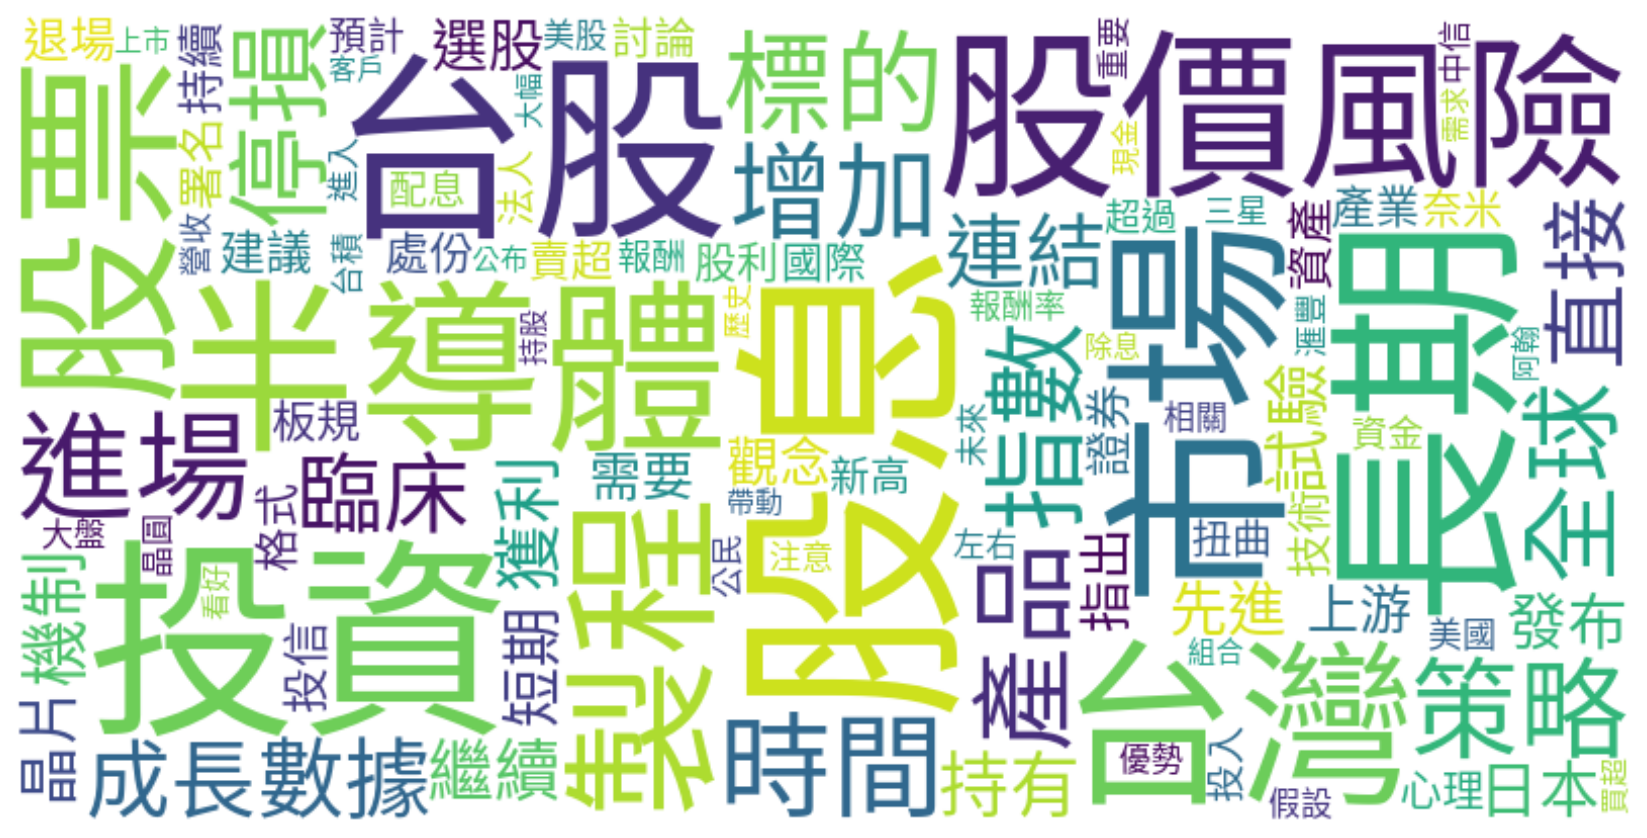

In [97]:
# 匯入自訂的 stop words (預設只有英文的)
stop_words_pos = stop_words
stop_words_pos.extend(('廣達','台積電','力積電','啟碁','長榮','標題','技嘉','緯創','富邦','合庫金','網址','光寶科','東陽','和碩','中鋼','群創','富邦金','遠東銀','中信金','聯電','鴻海','中磊','旺宏','宏碁',
                       '日月光','仁寶','英業達','台塑','精成科','聯發科','遠東銀','奇鋐','矽格','永豐','群益','元大','漢唐','文曄','國泰','聯強','奇鋐','欣興','裕民','景碩','健鼎','台新','京元','神達','中裕'))
stop_words_pos = set(stop_words_pos)

# 設定中文字形
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words_pos,
                collocations=False,
                font_path=FontPath,
                width=800, 
                height = 400, 
                max_words=100, 
                background_color="white")

wordcloud.generate(' '.join(pos_words['word']))
# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()